# Bayesian Clustering and Smoothing of Carbon Emissions Time Series

# Part 1 - Full Spline Coefficients (120-dim)

Same as Smoothing mean of sectors here we are applying the same process all over the steps we did before. Here this allows us to se how the outputs are same and how full coeff work.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from patsy import dmatrix
import plotly.graph_objects as go

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [5]:
from sklearn.metrics import mean_squared_error
import plotly.graph_objects as go

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

EU_data = pd.read_csv("/content/drive/MyDrive/Dataset/Europe_Carbon_Monitor_Final.csv")
EU_data['date'] = pd.to_datetime(EU_data['date'])
EU_data = EU_data[EU_data['country'] != 'EU27 & UK']
EU_data.dropna(inplace=True)

## How Spline Smoothing works

Smoothing a Country of choice

In [ ]:
# The plotting function
def plot_all_sectors_spline_subplots_no_legend(df, country_name, df_spline=20, degree=3, alpha=1.0):
    df_country = df[df["country"] == country_name].copy()
    df_country = df_country.sort_values("date").reset_index(drop=True)
    df_country['t'] = np.arange(len(df_country))

    sectors = ['Domestic Aviation', 'Ground Transport', 'Industry',
               'International Aviation', 'Power', 'Residential']
    colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3']

    fig = make_subplots(rows=3, cols=2, subplot_titles=sectors)

    for i, sector in enumerate(sectors):
        t = df_country['t'].values
        y = df_country[sector].values
        date = df_country['date']

        basis = dmatrix(f"bs(t, df={df_spline}, degree={degree}, include_intercept=True) - 1",
                        {"t": t}, return_type='dataframe')
        ridge = Ridge(alpha=alpha, fit_intercept=False)
        ridge.fit(basis, y)
        y_smooth = ridge.predict(basis)

        row = i // 2 + 1
        col = i % 2 + 1

        fig.add_trace(go.Scatter(x=date, y=y, mode='lines',
                                 line=dict(dash='dot', width=1),
                                 showlegend=False),
                      row=row, col=col)
        fig.add_trace(go.Scatter(x=date, y=y_smooth, mode='lines',
                                 line=dict(color=colors[i], width=2),
                                 showlegend=False),
                      row=row, col=col)

    fig.update_layout(
        height=900,
        width=1000,
        title_text=f"P-spline Smoothing for All Sectors - {country_name}",
        template="plotly_white",
        showlegend=False
    )

    return fig

# Generate the subplot visualization for a specific country
fig_germany = plot_all_sectors_spline_subplots_no_legend(EU_data, "Germany")
fig_germany.show()

All spline smooth plots in one

In [ ]:
def plot_all_sectors_spline_plotly(
    df: pd.DataFrame,
    country_name: str,
    df_spline: int = 20,
    degree: int = 3,
    alpha: float = 1.0,
    raw_opacity: float = 0.4,
    show_legend: bool = True
):
    # Filter & prepare
    df_country = df[df["country"] == country_name].copy()
    df_country = df_country.sort_values("date").reset_index(drop=True)
    df_country['t'] = np.arange(len(df_country))

    # Sectors & colors
    sectors = [
        'Domestic Aviation', 'Ground Transport', 'Industry',
        'International Aviation', 'Power', 'Residential'
    ]
    colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3']

    # Build figure
    fig = go.Figure()
    for i, sector in enumerate(sectors):
        t = df_country['t'].values
        y = df_country[sector].values
        dates = df_country['date']

        # Spline basis + Ridge fit
        basis = dmatrix(
            f"bs(t, df={df_spline}, degree={degree}, include_intercept=True) - 1",
            {"t": t}, return_type='dataframe'
        )
        ridge = Ridge(alpha=alpha, fit_intercept=False)
        ridge.fit(basis, y)
        y_smooth = ridge.predict(basis)

        # Raw trace
        fig.add_trace(go.Scatter(
            x=dates, y=y,
            mode='lines',
            name=f'{sector} (raw)',
            opacity=raw_opacity,
            line=dict(dash='dot'),
            showlegend=show_legend
        ))
        # Smoothed trace
        fig.add_trace(go.Scatter(
            x=dates, y=y_smooth,
            mode='lines',
            name=f'{sector} (smoothed)',
            line=dict(color=colors[i], width=2),
            showlegend=show_legend
        ))

    # Layout
    fig.update_layout(
        title=f"P-spline Smoothing for All Sectors — {country_name}",
        xaxis_title="Date",
        yaxis_title="Emissions (MtCO₂)",
        template="plotly_white"
    )
    fig.show()




In [ ]:
# Full legend:
plot_all_sectors_spline_plotly(EU_data, "Italy")
#plot_all_sectors_spline_plotly(EU_data, "Italy", show_legend=False)

## Parameter sensitivity Test

Testing if other configurations of hyperparam work better

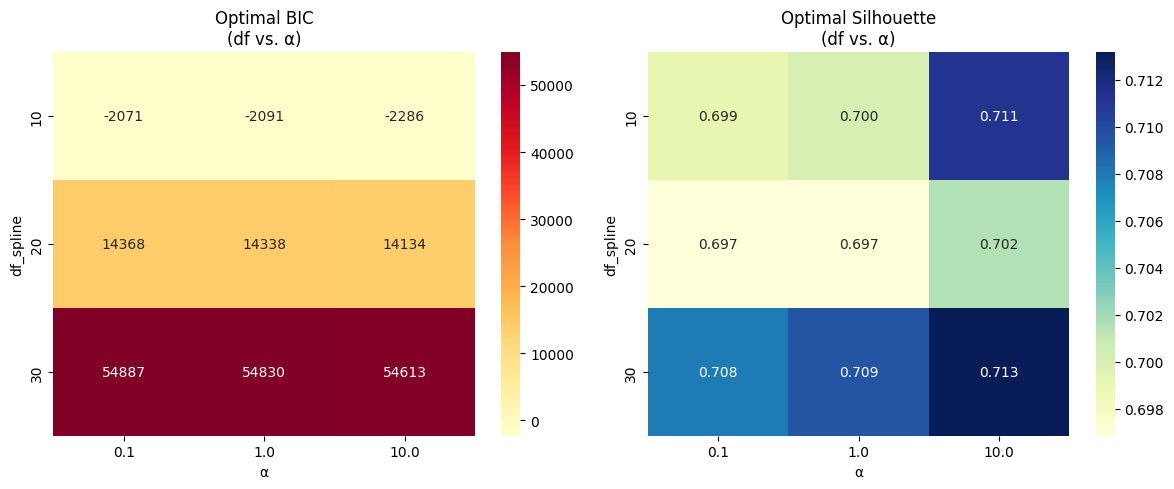

In [ ]:
sectors = ['Domestic Aviation', 'Ground Transport', 'Industry',
           'International Aviation', 'Power', 'Residential']

df_spline_list = [10, 20, 30]
alpha_list     = [0.1, 1.0, 10.0]
degree_fixed   = 3
countries = EU_data['country'].unique()

grid_results = []

for df_spline in df_spline_list:
    for alpha in alpha_list:
        # 1) Extract full‐coef features under this smoothing config
        all_coefs = []
        for country in countries:
            df_ct = (EU_data[EU_data['country']==country]
                     .sort_values('date')
                     .reset_index(drop=True))
            df_ct['t'] = np.arange(len(df_ct))

            country_coefs = []
            for sec in sectors:
                basis = dmatrix(
                    f"bs(t, df={df_spline}, degree={degree_fixed}, include_intercept=True)-1",
                    {"t": df_ct['t']}, return_type='dataframe'
                )
                y = df_ct[sec].values
                ridge = Ridge(alpha=alpha, fit_intercept=False).fit(basis, y)
                country_coefs.extend(ridge.coef_)
            all_coefs.append(country_coefs)

        X = np.array(all_coefs)  # shape [n_countries, df_spline*6]
        X_scaled = StandardScaler().fit_transform(X)

        # 2) Compute BIC & Silhouette over K=2…10
        bic_scores = []
        sil_scores = []
        for k in range(2, 11):
            gmm = GaussianMixture(n_components=k,
                                  covariance_type='full',
                                  random_state=42)
            gmm.fit(X_scaled)
            labels = gmm.predict(X_scaled)
            bic_scores.append(gmm.bic(X_scaled))
            sil_scores.append(silhouette_score(X_scaled, labels))

        # 3) Record the *best* metrics
        grid_results.append({
            'df_spline':       df_spline,
            'alpha':           alpha,
            'best_BIC':        min(bic_scores),
            'best_Silhouette': max(sil_scores)
        })

grid_df = pd.DataFrame(grid_results)

# 4) Pivot into heatmap‐friendly form
pivot_bic = grid_df.pivot(index='df_spline',
                          columns='alpha',
                          values='best_BIC')
pivot_sil= grid_df.pivot(index='df_spline',
                         columns='alpha',
                         values='best_Silhouette')

# 5) Plot
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.heatmap(pivot_bic, annot=True, fmt=".0f", cmap="YlOrRd")
plt.title("Optimal BIC\n(df vs. α)")
plt.xlabel("α")
plt.ylabel("df_spline")

plt.subplot(1,2,2)
sns.heatmap(pivot_sil, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Optimal Silhouette\n(df vs. α)")
plt.xlabel("α")
plt.ylabel("df_spline")

plt.tight_layout()
plt.show()


## Spline Validation on overlapping periods

Calculating the RMSE between the ovelapping periods and trimmed spline curves

In [ ]:
# --- Parameters ---
df_spline = 20
degree = 3
alpha = 1.0

# --- Function to compute spline RMSE between two overlapping periods ---
def compute_spline_rmse(country, sector):
    df_country = EU_data[EU_data["country"] == country].sort_values("date").reset_index(drop=True)
    df_country['t'] = np.arange(len(df_country))

    # Define two fitting periods
    p1_start, p1_end = '2019-01-01', '2023-01-01'
    p2_start, p2_end = '2020-01-01', '2024-01-01'

    df1 = df_country[(df_country['date'] >= p1_start) & (df_country['date'] < p1_end)]
    df2 = df_country[(df_country['date'] >= p2_start) & (df_country['date'] < p2_end)]
    if df1.empty or df2.empty:
        return None

    # Fit splines
    X1 = dmatrix(f"bs(t, df={df_spline}, degree={degree}, include_intercept=True) - 1",
                 {"t": df1['t']}, return_type='dataframe')
    m1 = Ridge(alpha=alpha, fit_intercept=False).fit(X1, df1[sector])
    y1 = m1.predict(X1)

    X2 = dmatrix(f"bs(t, df={df_spline}, degree={degree}, include_intercept=True) - 1",
                 {"t": df2['t']}, return_type='dataframe')
    m2 = Ridge(alpha=alpha, fit_intercept=False).fit(X2, df2[sector])
    y2 = m2.predict(X2)

    # Compute RMSE on overlapping dates
    overlap_dates = df1['date'].isin(df2['date'])
    idx1 = df1[overlap_dates].index
    idx2 = df2[df2['date'].isin(df1['date'])].index
    if len(idx1) == 0:
        return None

    rmse = np.sqrt(mean_squared_error(y1[idx1], y2[idx2]))
    return {'country': country, 'sector': sector, 'rmse_overlap': rmse}

# --- Batch processing to build RMSE table ---
sectors = ['Domestic Aviation', 'Ground Transport', 'Industry',
           'International Aviation', 'Power', 'Residential']
countries = EU_data['country'].unique()

results = []
for country in countries:
    for sector in sectors:
        res = compute_spline_rmse(country, sector)
        if res:
            results.append(res)

results_df = pd.DataFrame(results)
print("RMSE overlap summary (first 10 rows):")
print(results_df.head(10))

# --- Function to plot trimmed overlap of smoothed splines ---
def plot_trimmed_overlap(country, sector):
    df_country = EU_data[EU_data["country"] == country].sort_values("date").reset_index(drop=True)
    df_country['t'] = np.arange(len(df_country))

    # Define periods
    fit1_start, fit1_end = '2019-01-01', '2023-01-01'
    fit2_start, fit2_end = '2020-01-01', '2024-01-01'
    overlap_start, overlap_end = '2020-01-01', '2023-01-01'

    df1 = df_country[(df_country['date'] >= fit1_start) & (df_country['date'] < fit1_end)].copy()
    df2 = df_country[(df_country['date'] >= fit2_start) & (df_country['date'] < fit2_end)].copy()

    # Fit splines
    for df_period in (df1, df2):
        X = dmatrix(f"bs(t, df={df_spline}, degree={degree}, include_intercept=True) - 1",
                    {"t": df_period['t']}, return_type='dataframe')
        model = Ridge(alpha=alpha, fit_intercept=False).fit(X, df_period[sector])
        df_period['y_smooth'] = model.predict(X)

    # Filter overlap
    df1_o = df1[(df1['date'] >= overlap_start) & (df1['date'] < overlap_end)]
    df2_o = df2[(df2['date'] >= overlap_start) & (df2['date'] < overlap_end)]

    # Plot
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df1_o['date'], y=df1_o['y_smooth'],
                             mode='lines', name="Fit 2019–2023", line=dict(color='blue')))
    fig.add_trace(go.Scatter(x=df2_o['date'], y=df2_o['y_smooth'],
                             mode='lines', name="Fit 2020–2024",
                             line=dict(color='orange', dash='dash')))
    fig.update_layout(
        title=f"Spline Overlap: {country} — {sector}",
        xaxis_title="Date",
        yaxis_title="Emissions (smoothed)",
        template="plotly_white",
        annotations=[dict(
            text="Overlap region (2020–2023) highlights fit consistency",
            xref='paper', yref='paper', x=0, y=-0.15, showarrow=False
        )]
    )
    fig.show()

# Example visualization
plot_trimmed_overlap("Germany", "Power")


RMSE overlap summary (first 10 rows):
   country                  sector  rmse_overlap
0  Austria       Domestic Aviation      0.000048
1  Austria        Ground Transport      0.002607
2  Austria                Industry      0.016806
3  Austria  International Aviation      0.002282
4  Austria                   Power      0.011202
5  Austria             Residential      0.002534
6  Belgium       Domestic Aviation      0.000013
7  Belgium        Ground Transport      0.004995
8  Belgium                Industry      0.008765
9  Belgium  International Aviation      0.002497


In [ ]:
plot_trimmed_overlap("Spain", "Industry")
plot_trimmed_overlap("Italy", "Ground Transport")
plot_trimmed_overlap("Malta", "International Aviation")

In [ ]:
countries

array(['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus',
       'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France',
       'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia',
       'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Norway',
       'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain',
       'Sweden', 'Switzerland', 'United Kingdom'], dtype=object)

In [ ]:
# --- Function to compute spline RMSE between two overlapping periods ---
def compute_spline_rmse(country, sector):
    df_country = EU_data[EU_data["country"] == country].sort_values("date").reset_index(drop=True)
    df_country['t'] = np.arange(len(df_country))

    # Define periods
    p1_start, p1_end = '2019-01-01', '2023-01-01'
    p2_start, p2_end = '2020-01-01', '2024-01-01'

    df1 = df_country[(df_country['date'] >= p1_start) & (df_country['date'] < p1_end)]
    df2 = df_country[(df_country['date'] >= p2_start) & (df_country['date'] < p2_end)]
    if df1.empty or df2.empty:
        return None

    # Fit splines for both periods
    X1 = dmatrix(f"bs(t, df={df_spline}, degree={degree}, include_intercept=True) - 1",
                 {"t": df1['t']}, return_type='dataframe')
    m1 = Ridge(alpha=alpha, fit_intercept=False).fit(X1, df1[sector])
    y1 = m1.predict(X1)

    X2 = dmatrix(f"bs(t, df={df_spline}, degree={degree}, include_intercept=True) - 1",
                 {"t": df2['t']}, return_type='dataframe')
    m2 = Ridge(alpha=alpha, fit_intercept=False).fit(X2, df2[sector])
    y2 = m2.predict(X2)

    # Compute RMSE on overlapping dates
    overlap_mask = df1['date'].isin(df2['date'])
    if not overlap_mask.any():
        return None

    idx1 = df1[overlap_mask].index
    idx2 = df2[df2['date'].isin(df1['date'])].index
    rmse = np.sqrt(mean_squared_error(y1[idx1], y2[idx2]))
    return {'country': country, 'sector': sector, 'rmse_overlap': rmse}

# --- Batch processing to build RMSE DataFrame ---
results = []
for country in countries:
    for sector in sectors:
        res = compute_spline_rmse(country, sector)
        if res:
            results.append(res)

results_df = pd.DataFrame(results)

# --- Compute average RMSE across sectors and overall ---
sector_rmse_summary = results_df.groupby("sector")["rmse_overlap"].mean().rename("avg_rmse")
overall_avg_rmse = sector_rmse_summary.mean()

# Display results
print("Average RMSE across sectors:")
print(sector_rmse_summary.to_frame())
print(f"\nOverall average RMSE: {overall_avg_rmse:.4f}")


Average RMSE across sectors:
                        avg_rmse
sector                          
Domestic Aviation       0.000494
Ground Transport        0.006158
Industry                0.005479
International Aviation  0.004173
Power                   0.016654
Residential             0.005849

Overall average RMSE: 0.0065


## Feature Extraction - Spline coefficients

Exctracting the spline features for clustering. Here we are not considering the mean of the curve but spline coeff of 20.

In [ ]:
df_spline = 20
degree = 3
alpha = 1.0

# --- Feature Extraction: spline coefficients ---
features = []
for country in countries:
    df_country = EU_data[EU_data["country"] == country].sort_values("date").reset_index(drop=True)
    df_country['t'] = np.arange(len(df_country))
    coefs = []
    for sector in sectors:
        basis = dmatrix(
            f"bs(t, df={df_spline}, degree={degree}, include_intercept=True) - 1",
            {"t": df_country['t']},
            return_type='dataframe'
        )
        ridge = Ridge(alpha=alpha, fit_intercept=False).fit(basis, df_country[sector])
        coefs.extend(ridge.coef_)
    features.append(coefs)

X = np.array(features)
X_scaled = StandardScaler().fit_transform(X)

In [ ]:
print(features)

[[np.float64(8.458477276031623e-05), np.float64(0.00013116205342952812), np.float64(0.0001267743534186316), np.float64(0.0001943162830582249), np.float64(0.00011686054511988469), np.float64(8.066981651767954e-05), np.float64(0.00019261604486454017), np.float64(-5.0382341637953765e-06), np.float64(0.0002614145719387909), np.float64(0.0001477862700699731), np.float64(3.4137828154853236e-05), np.float64(0.00013387799860104112), np.float64(6.716656884592734e-05), np.float64(7.402493465597845e-05), np.float64(0.00014528049496824268), np.float64(6.790242837722359e-05), np.float64(0.00012231942160917622), np.float64(0.00022017021229294267), np.float64(0.00018596698297817577), np.float64(0.00014654517075768516), np.float64(0.054432093210062704), np.float64(0.07117383881810971), np.float64(0.06138924001711668), np.float64(0.06992997191083773), np.float64(0.0645494110812887), np.float64(0.05820667151216998), np.float64(0.07728341742266576), np.float64(0.054010570877064026), np.float64(0.07290994

In [ ]:
print(X_scaled)

[[-0.52912358 -0.56716617 -0.51674914 ...  0.04594022 -0.31479797
  -0.3308042 ]
 [-0.5544228  -0.60618551 -0.54816312 ...  0.26898578  0.07686078
   0.04074925]
 [-0.54456569 -0.60881522 -0.53376491 ...  0.3101788  -0.56708601
  -0.58443893]
 ...
 [-0.06026318  0.43915218 -0.06462891 ...  0.25970849 -0.56419542
  -0.59088189]
 [-0.51148276 -0.53963777 -0.47499524 ...  0.01365878 -0.19715499
  -0.16684578]
 [ 0.64319497  0.81104385  0.88461299 ...  1.31903107  1.7486385
   1.29685096]]


## Model selection via BIC and Silhouette

In [ ]:
# --- Model selection via BIC and Silhouette ---
results = []
Ks = range(2, 11)  # test cluster counts from 2 to 10
for k in Ks:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm.fit(X_scaled)
    bic = gmm.bic(X_scaled)
    labels = gmm.predict(X_scaled)
    sil_score = silhouette_score(X_scaled, labels)
    results.append({'n_clusters': k, 'BIC': bic, 'Silhouette': sil_score})

results_df = pd.DataFrame(results)
print("Model selection metrics:")
print(results_df)



Model selection metrics:
   n_clusters            BIC  Silhouette
0           2   14338.213133    0.696875
1           3   37301.410025    0.390708
2           4   62237.993043    0.355442
3           5   87141.077767    0.377785
4           6  112211.568405    0.355815
5           7  137243.512244    0.376163
6           8  162313.493586    0.376671
7           9  186548.562853    0.340528
8          10  211973.914239    0.298165


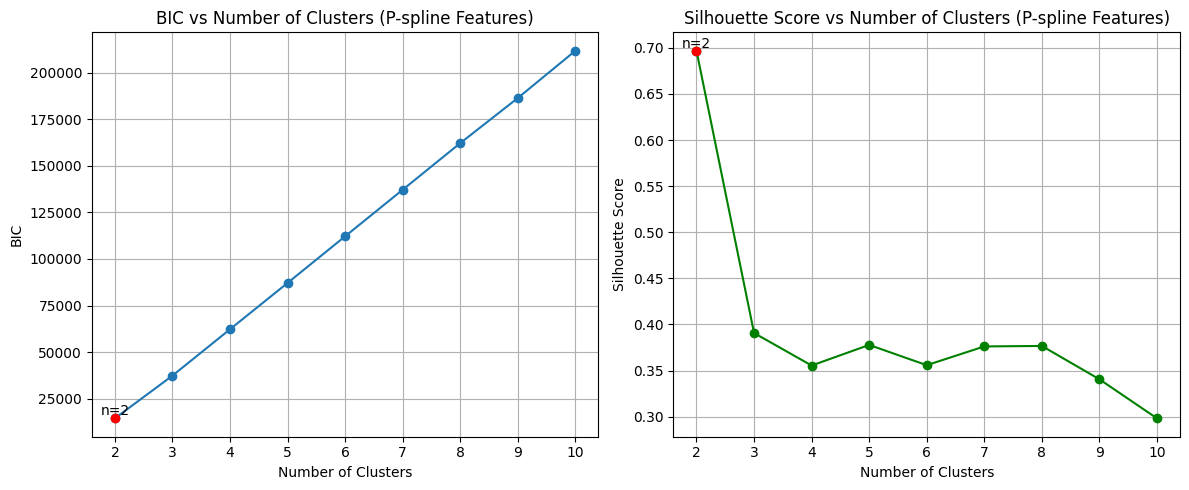

Best BIC at n=2: 14338.21
Best Silhouette Score at n=2: 0.6969


In [ ]:
bic_scores, silhouette_scores = [], []
n_components_range = range(2, 11)

for n in n_components_range:
    gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=42)
    gmm.fit(X_scaled)
    labels = gmm.predict(X_scaled)

    bic_scores.append(gmm.bic(X_scaled))
    silhouette_scores.append(silhouette_score(X_scaled, labels))

# Identifying optimal values
optimal_bic_n = n_components_range[np.argmin(bic_scores)]
optimal_sil_n = n_components_range[np.argmax(silhouette_scores)]

# Plot results
plt.figure(figsize=(12, 5))

# BIC Plot
plt.subplot(1, 2, 1)
plt.plot(n_components_range, bic_scores, marker='o', label='BIC')
plt.scatter(optimal_bic_n, min(bic_scores), color='red', zorder=5)
plt.text(optimal_bic_n, min(bic_scores), f"n={optimal_bic_n}", va='bottom', ha='center')
plt.title('BIC vs Number of Clusters (P-spline Features)')
plt.xlabel('Number of Clusters')
plt.ylabel('BIC')
plt.grid(True)

# Silhouette Plot
plt.subplot(1, 2, 2)
plt.plot(n_components_range, silhouette_scores, marker='o', color='green', label='Silhouette')
plt.scatter(optimal_sil_n, max(silhouette_scores), color='red', zorder=5)
plt.text(optimal_sil_n, max(silhouette_scores), f"n={optimal_sil_n}", va='bottom', ha='center')
plt.title('Silhouette Score vs Number of Clusters (P-spline Features)')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Best BIC at n={optimal_bic_n}: {min(bic_scores):.2f}")
print(f"Best Silhouette Score at n={optimal_sil_n}: {max(silhouette_scores):.4f}")


## GMM Model with Optimal Clusters

In [ ]:
import pandas as pd
import numpy as np
from patsy import dmatrix
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

optimal_k = 2

In [ ]:
# --- 3) Fit final GMM ---
gmm = GaussianMixture(n_components=optimal_k, covariance_type='full', random_state=42)
gmm.fit(X_scaled)
labels = gmm.predict(X_scaled)
responsibilities = gmm.predict_proba(X_scaled)
active_clusters = np.unique(labels)

In [ ]:
print(active_clusters)

[0 1]


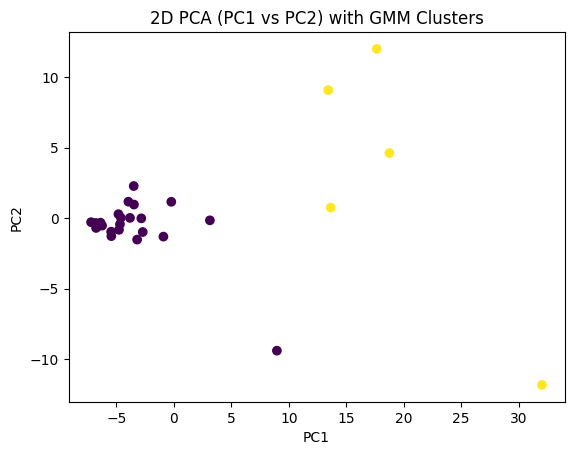

In [ ]:
# --- 4) PCA for visualization ---
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# 4a) 2D PCA plot (PC1 vs PC2)
plt.figure()
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels)
plt.title('2D PCA (PC1 vs PC2) with GMM Clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

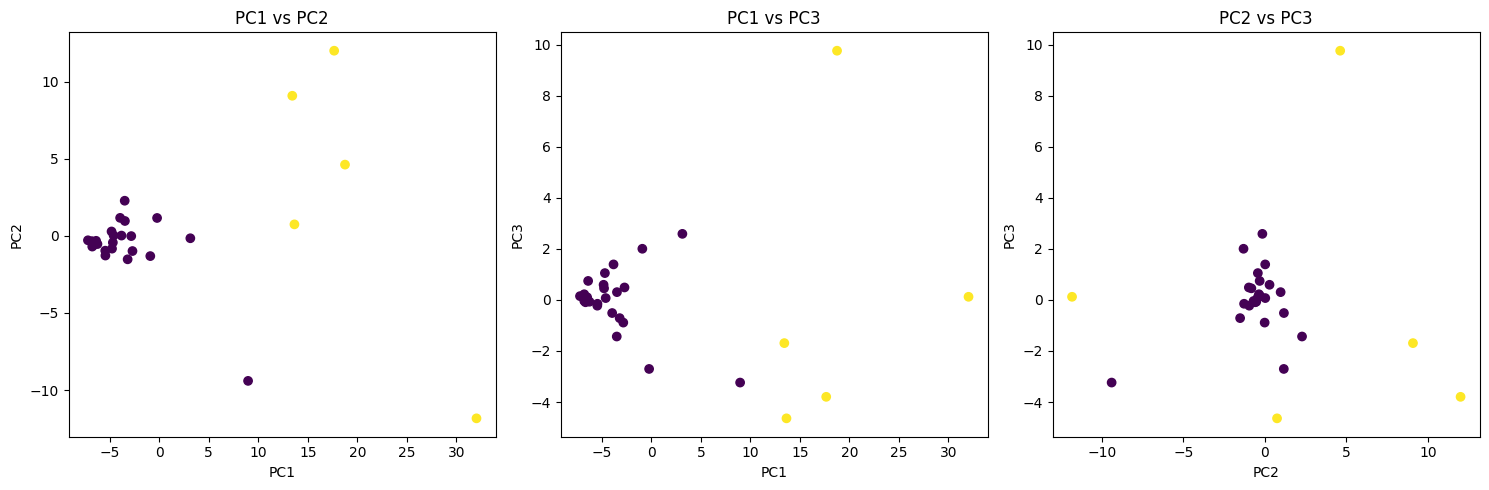

In [ ]:
# 4b) Trellis of pairwise PCA components
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
pairs = [(0,1), (0,2), (1,2)]
for ax, (i, j) in zip(axes, pairs):
    ax.scatter(X_pca[:,i], X_pca[:,j], c=labels)
    ax.set_xlabel(f'PC{i+1}')
    ax.set_ylabel(f'PC{j+1}')
    ax.set_title(f'PC{i+1} vs PC{j+1}')
plt.tight_layout()
plt.show()

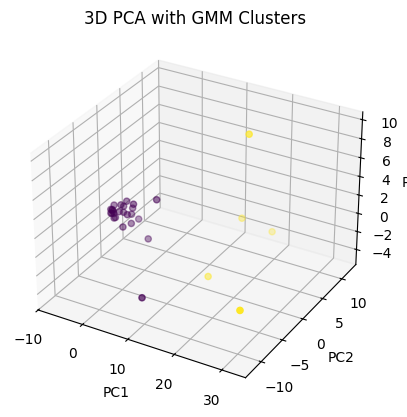

In [ ]:
# 4c) 3D PCA plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=labels)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('3D PCA with GMM Clusters')
plt.show()

In [ ]:
# --- 5) Cluster assignments and posterior probs ---
cluster_df = pd.DataFrame({
    'country': countries,
    'cluster': labels,
    'posterior_prob': responsibilities.max(axis=1)
})
cluster_df_sorted = cluster_df.sort_values(by='cluster').reset_index(drop=True)

# Display cluster table and active clusters
print("Active clusters:", active_clusters)
print(cluster_df_sorted)

Active clusters: [0 1]
           country  cluster  posterior_prob
0          Austria        0             1.0
1          Belgium        0             1.0
2         Bulgaria        0             1.0
3          Croatia        0             1.0
4           Cyprus        0             1.0
5   Czech Republic        0             1.0
6          Denmark        0             1.0
7          Estonia        0             1.0
8          Finland        0             1.0
9           Greece        0             1.0
10         Ireland        0             1.0
11         Hungary        0             1.0
12          Latvia        0             1.0
13           Malta        0             1.0
14      Luxembourg        0             1.0
15       Lithuania        0             1.0
16        Slovakia        0             1.0
17        Slovenia        0             1.0
18          Sweden        0             1.0
19     Netherlands        0             1.0
20          Norway        0             1.0
21       

## BGMM with Dirichlet Process

In [ ]:
import pandas as pd
import numpy as np
from patsy import dmatrix
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import BayesianGaussianMixture
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [ ]:
# --- 1) Extract spline coefficients and full smoothed series ---
features = []
smoothed = {}  # country -> sector -> (dates, y_smooth)
for country in countries:
    df_ct = EU_data[EU_data['country']==country].sort_values('date').reset_index(drop=True)
    df_ct['t'] = np.arange(len(df_ct))
    coefs = []
    smoothed[country] = {}
    # build basis once
    basis = dmatrix(f"bs(t, df={df_spline}, degree={degree}, include_intercept=True)-1",
                    {"t": df_ct['t']}, return_type='dataframe')
    for sector in sectors:
        y = df_ct[sector].values
        model = Ridge(alpha=alpha, fit_intercept=False).fit(basis, y)
        # coefficients
        coefs.extend(model.coef_)
        # full smoothed series
        smoothed[country][sector] = model.predict(basis)
    features.append(coefs)

X = np.array(features)

# --- 2) Standardize ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
print(X_scaled)

[[-5.34799422e-01 -5.47654539e-01 -5.51764768e-01 ... -3.54057974e-01
  -3.22812686e-01 -3.31036992e-01]
 [-5.60673898e-01 -5.81927958e-01 -5.86214448e-01 ...  1.57232703e-01
   6.46953073e-02  4.25489303e-02]
 [-5.54331124e-01 -5.74849534e-01 -5.83872181e-01 ... -5.82596988e-01
  -5.76780339e-01 -5.84444866e-01]
 ...
 [ 6.33686891e-04  1.72829681e-01  2.51844518e-01 ... -5.84057188e-01
  -5.80835675e-01 -5.88865691e-01]
 [-5.17190179e-01 -5.22459814e-01 -5.16971261e-01 ... -2.03687248e-01
  -1.93747389e-01 -1.64400054e-01]
 [ 6.88042195e-01  6.96013356e-01  9.09421355e-01 ...  2.41253265e+00
   1.56851284e+00  1.33081401e+00]]


In [ ]:
# --- Parameters ---
df_spline = 20
degree = 3
alpha = 1.0
n_components = 10  # truncation for DP
weight_concentration_prior = 0.5

# --- 3) Fit DP-BGMM ---
dpbgmm = BayesianGaussianMixture(
    n_components=n_components,
    weight_concentration_prior=weight_concentration_prior,
    weight_concentration_prior_type='dirichlet_process',
    covariance_type='full',
    max_iter=1000,
    random_state=42
).fit(X_scaled)
labels = dpbgmm.predict(X_scaled)
responsibilities = dpbgmm.predict_proba(X_scaled)
active_clusters = np.unique(labels)
print(active_clusters)

[0 1 2 3 4 5 6 7 8 9]


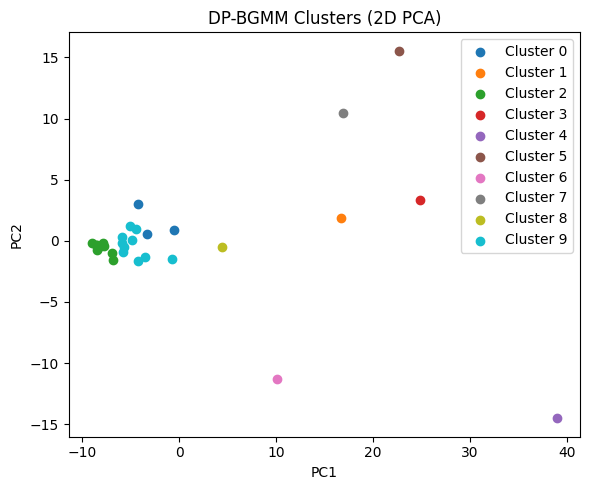

In [ ]:
# --- 4) PCA for visualization ---
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# 4a) 2D PCA
plt.figure(figsize=(6,5))
for cl in active_clusters:
    idx = labels==cl
    plt.scatter(X_pca[idx,0], X_pca[idx,1], label=f'Cluster {cl}')
plt.title('DP-BGMM Clusters (2D PCA)')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.legend()
plt.tight_layout()
plt.show()

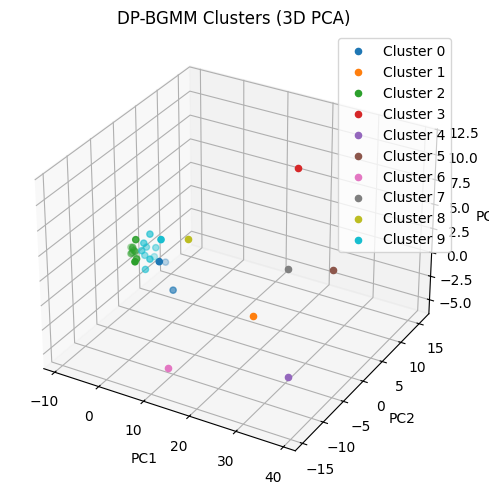

In [ ]:
# 4b) 3D PCA
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
for cl in active_clusters:
    idx = labels==cl
    ax.scatter(X_pca[idx,0], X_pca[idx,1], X_pca[idx,2], label=f'Cluster {cl}')
ax.set_title('DP-BGMM Clusters (3D PCA)')
ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_zlabel('PC3')
ax.legend()
plt.tight_layout()
plt.show()

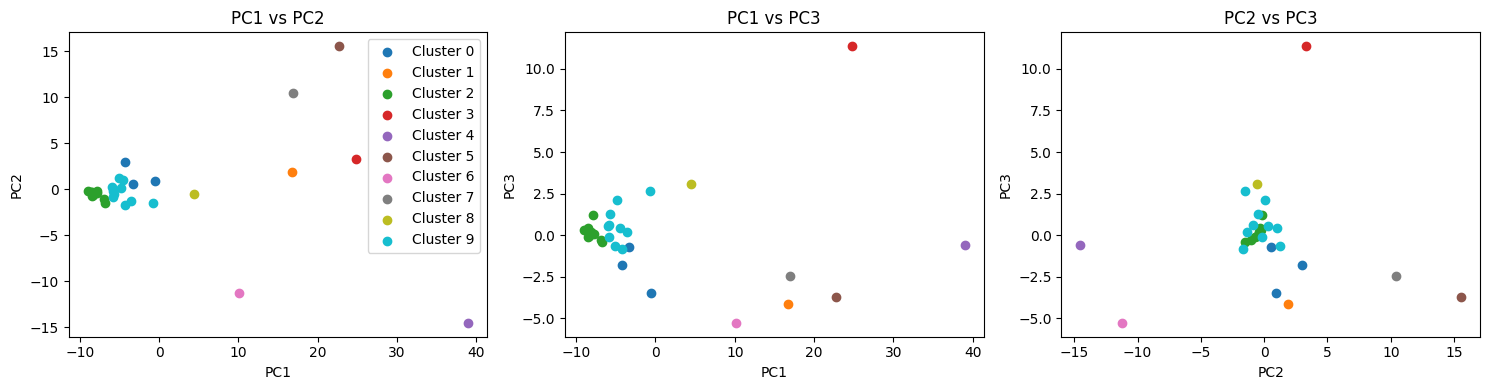

In [ ]:
# 4c) Trellis: PC1 vs PC2, PC1 vs PC3, PC2 vs PC3
fig, axes = plt.subplots(1,3,figsize=(15,4))
pairs = [(0,1),(0,2),(1,2)]
for ax, (i,j) in zip(axes, pairs):
    for cl in active_clusters:
        idx = labels==cl
        ax.scatter(X_pca[idx,i], X_pca[idx,j], label=f'Cluster {cl}')
    ax.set_xlabel(f'PC{i+1}'); ax.set_ylabel(f'PC{j+1}')
    ax.set_title(f'PC{i+1} vs PC{j+1}')
axes[0].legend()
plt.tight_layout()
plt.show()

In [ ]:
# --- 5) Country assignments & posterior probs ---
cluster_df = pd.DataFrame({
    'country': countries,
    'cluster': labels,
    'posterior_prob': responsibilities.max(axis=1)
})
print("Active clusters:", active_clusters)
print(cluster_df.sort_values('cluster').to_string(index=False))

Active clusters: [0 1 2 3 4 5 6 7 8 9]
       country  cluster  posterior_prob
Czech Republic        0             1.0
        Greece        0             1.0
        Norway        0             1.0
         Italy        1             1.0
       Estonia        2             1.0
        Latvia        2             1.0
        Cyprus        2             1.0
       Croatia        2             1.0
    Luxembourg        2             1.0
         Malta        2             1.0
      Slovakia        2             1.0
      Slovenia        2             1.0
     Lithuania        2             1.0
      Bulgaria        2             1.0
United Kingdom        3             1.0
       Germany        4             1.0
        France        5             1.0
        Poland        6             1.0
         Spain        7             1.0
   Netherlands        8             1.0
       Austria        9             1.0
       Belgium        9             1.0
       Finland        9             1.0
 

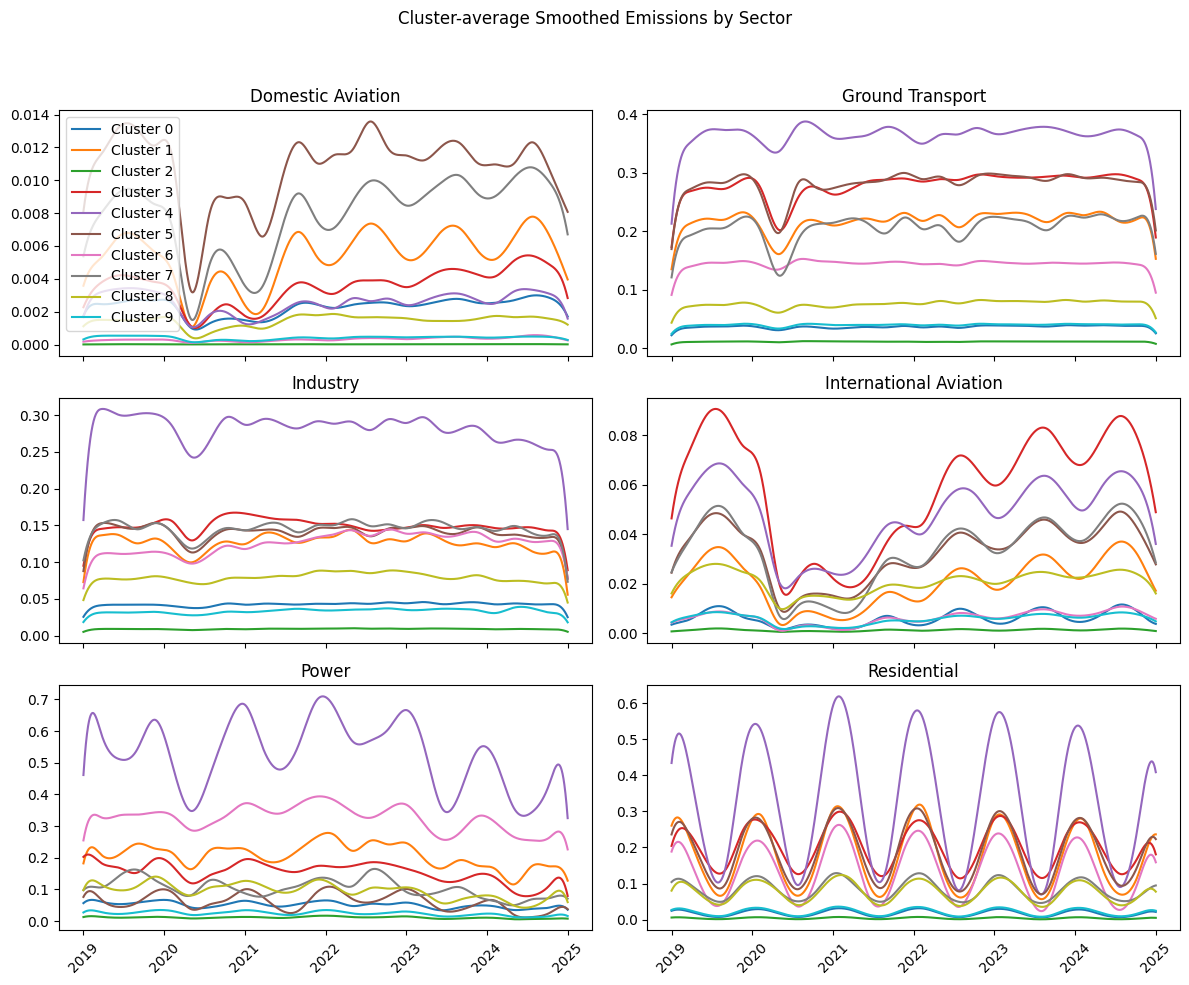

In [ ]:
# --- 6) Sector-level cluster differences ---
# average smoothed emission per cluster & sector
dates = EU_data[EU_data['country']==countries[0]]['date']
fig, axes = plt.subplots(3,2, figsize=(12,10), sharex=True)
axes = axes.flatten()
for i, sector in enumerate(sectors):
    ax = axes[i]
    for cl in active_clusters:
        # collect smoothed arrays for countries in this cluster
        arrs = [smoothed[c][sector] for c, lab in zip(countries, labels) if lab==cl]
        if arrs:
            mean_series = np.mean(arrs, axis=0)
            ax.plot(dates, mean_series, label=f'Cluster {cl}')
    ax.set_title(sector)
    ax.tick_params(axis='x', rotation=45)
axes[0].legend(loc='upper left')
plt.suptitle('Cluster-average Smoothed Emissions by Sector')
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


## Comparison GMM vs BGMM

In [ ]:
import pandas as pd
import numpy as np
from patsy import dmatrix
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

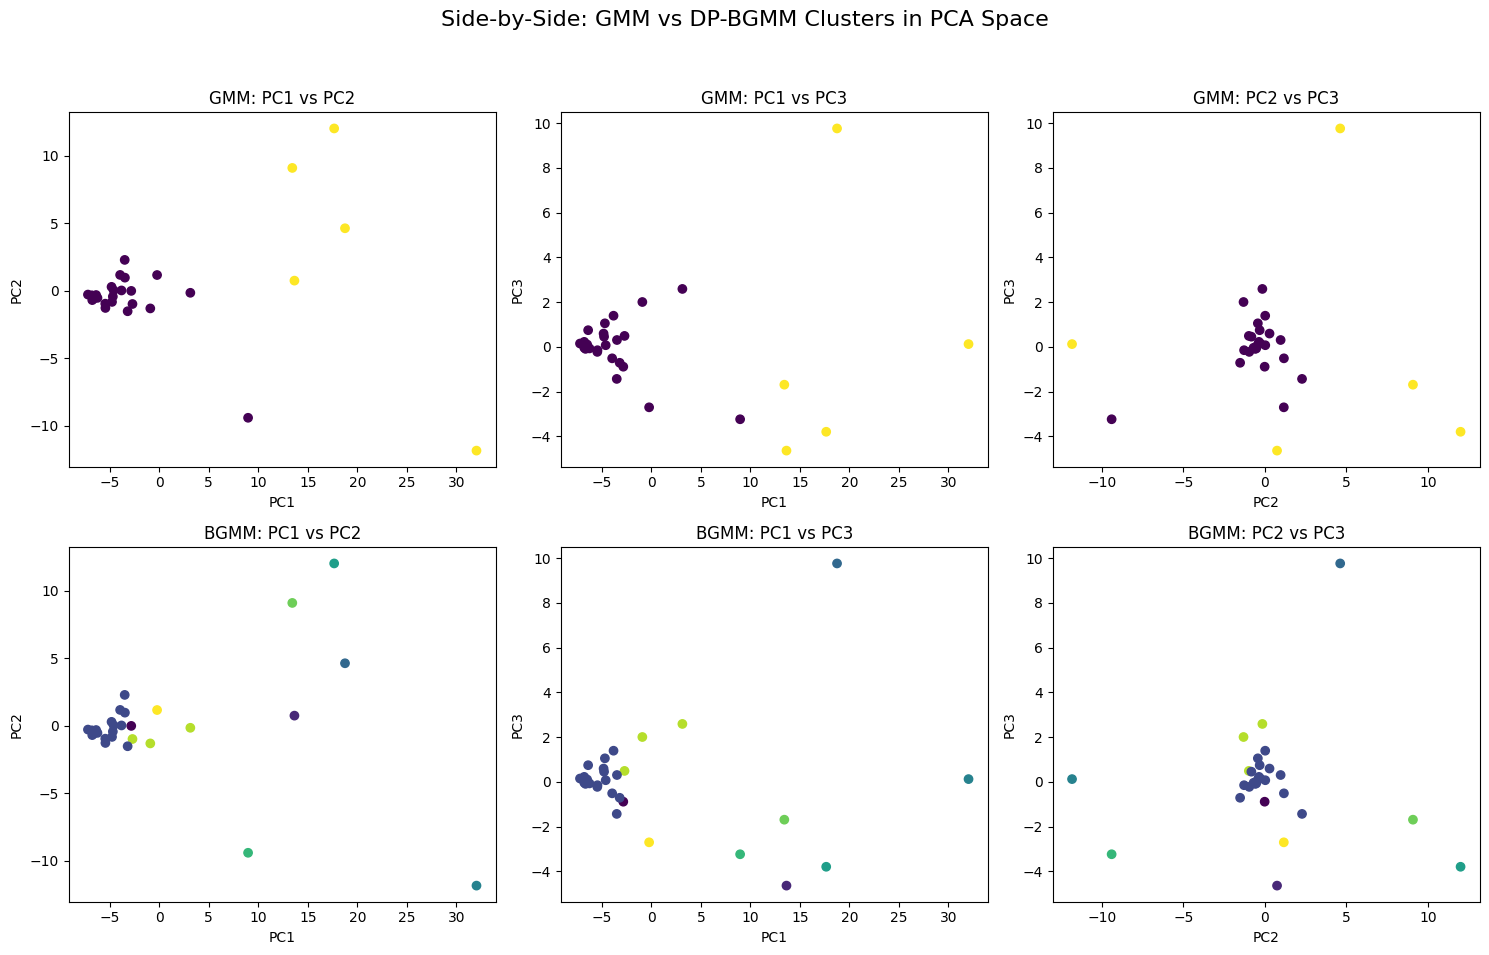

In [ ]:
# --- Parameters ---
df_spline = 20
degree = 3
alpha = 1.0
optimal_k = 2
dp_components = 10
dp_alpha = 0.5

# --- Feature extraction ---
features = []
for country in countries:
    df_ct = EU_data[EU_data['country'] == country].sort_values('date').reset_index(drop=True)
    df_ct['t'] = np.arange(len(df_ct))
    basis = dmatrix(
        f"bs(t, df={df_spline}, degree={degree}, include_intercept=True)-1",
        {"t": df_ct['t']},
        return_type='dataframe'
    )
    coefs = []
    for sector in sectors:
        y = df_ct[sector].values
        model = Ridge(alpha=alpha, fit_intercept=False).fit(basis, y)
        coefs.extend(model.coef_)
    features.append(coefs)

X = np.array(features)

# --- Standardize & PCA ---
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# --- Fit GMM ---
gmm = GaussianMixture(n_components=optimal_k, covariance_type='full', random_state=42)
gmm.fit(X_scaled)
gmm_labels = gmm.predict(X_scaled)

# --- Fit DP-BGMM ---
dpbgmm = BayesianGaussianMixture(
    n_components=dp_components,
    weight_concentration_prior=dp_alpha,
    weight_concentration_prior_type='dirichlet_process',
    covariance_type='full',
    max_iter=1000,
    random_state=42
).fit(X_scaled)
bgmm_labels = dpbgmm.predict(X_scaled)

# --- Plot comparison ---
pairs = [(0,1), (0,2), (1,2)]
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for col, (i, j) in enumerate(pairs):
    # GMM row
    ax = axes[0, col]
    ax.scatter(X_pca[:, i], X_pca[:, j], c=gmm_labels, cmap=None)
    ax.set_title(f'GMM: PC{i+1} vs PC{j+1}')
    ax.set_xlabel(f'PC{i+1}')
    ax.set_ylabel(f'PC{j+1}')
    # BGMM row
    ax = axes[1, col]
    ax.scatter(X_pca[:, i], X_pca[:, j], c=bgmm_labels, cmap=None)
    ax.set_title(f'BGMM: PC{i+1} vs PC{j+1}')
    ax.set_xlabel(f'PC{i+1}')
    ax.set_ylabel(f'PC{j+1}')

fig.suptitle('Side-by-Side: GMM vs DP-BGMM Clusters in PCA Space', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from patsy import dmatrix
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.decomposition import PCA
import plotly.express as px


# --- Fit GMM and DP-BGMM ---
gmm = GaussianMixture(n_components=optimal_k, covariance_type='full', random_state=42).fit(X_scaled)
gmm_labels = gmm.predict(X_scaled)

bgmm = BayesianGaussianMixture(
    n_components=dp_components,
    weight_concentration_prior=dp_alpha,
    weight_concentration_prior_type='dirichlet_process',
    covariance_type='full',
    max_iter=1000,
    random_state=42
).fit(X_scaled)
bgmm_labels = bgmm.predict(X_scaled)

# --- PCA projection ---
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# --- Prepare DataFrames ---
pca_df_gmm = pd.DataFrame({
    'PCA1': X_pca[:,0], 'PCA2': X_pca[:,1], 'PCA3': X_pca[:,2],
    'Country': countries, 'Cluster': gmm_labels.astype(str)
})

pca_df_bgmm = pd.DataFrame({
    'PCA1': X_pca[:,0], 'PCA2': X_pca[:,1], 'PCA3': X_pca[:,2],
    'Country': countries, 'Cluster': bgmm_labels.astype(str)
})

# --- GMM Trellis via Plotly scatter_matrix ---
fig_gmm_matrix = px.scatter_matrix(
    pca_df_gmm,
    dimensions=['PCA1','PCA2','PCA3'],
    color='Cluster',
    title='Trellis View of GMM Clusters in PCA Space'
)
fig_gmm_matrix.update_layout(width=700, height=700)
fig_gmm_matrix.show()

# --- GMM 3D scatter ---
fig_gmm_3d = px.scatter_3d(
    pca_df_gmm, x='PCA1', y='PCA2', z='PCA3',
    color='Cluster', hover_name='Country',
    title="3D PCA Projection with GMM Clusters"
)
fig_gmm_3d.show()

# --- DP-BGMM Trellis via Plotly scatter_matrix ---
fig_bgmm_matrix = px.scatter_matrix(
    pca_df_bgmm,
    dimensions=['PCA1','PCA2','PCA3'],
    color='Cluster',
    title='Trellis View of DP-BGMM Clusters in PCA Space'
)
fig_bgmm_matrix.update_layout(width=700, height=700)
fig_bgmm_matrix.show()

# --- DP-BGMM 3D scatter ---
fig_bgmm_3d = px.scatter_3d(
    pca_df_bgmm, x='PCA1', y='PCA2', z='PCA3',
    color='Cluster', hover_name='Country',
    title="3D PCA Projection with DP-BGMM Clusters"
)
fig_bgmm_3d.show()


In [ ]:

# Build a single DataFrame
cluster_df = pd.DataFrame({
    'Country': countries,
    'GMM_Cluster': gmm_labels,
    'BGMM_Cluster': bgmm_labels
}).set_index('Country')

# Print GMM cluster members
for c in sorted(cluster_df['GMM_Cluster'].unique()):
    members = cluster_df.index[cluster_df['GMM_Cluster'] == c].tolist()
    print(f"\nGMM Cluster {c}:")
    print(members)

# Print DP-BGMM cluster members
for c in sorted(cluster_df['BGMM_Cluster'].unique()):
    members = cluster_df.index[cluster_df['BGMM_Cluster'] == c].tolist()
    print(f"\nDP-BGMM Cluster {c}:")
    print(members)



GMM Cluster 0:
['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'Greece', 'Hungary', 'Ireland', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Norway', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Sweden', 'Switzerland']

GMM Cluster 1:
['France', 'Germany', 'Italy', 'Spain', 'United Kingdom']

DP-BGMM Cluster 0:
['Greece']

DP-BGMM Cluster 1:
['Italy']

DP-BGMM Cluster 2:
['Bulgaria', 'Croatia', 'Cyprus', 'Denmark', 'Estonia', 'Finland', 'Hungary', 'Ireland', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Norway', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Sweden', 'Switzerland']

DP-BGMM Cluster 3:
['United Kingdom']

DP-BGMM Cluster 4:
['Germany']

DP-BGMM Cluster 5:
['France']

DP-BGMM Cluster 6:
['Poland']

DP-BGMM Cluster 7:
['Spain']

DP-BGMM Cluster 8:
['Austria', 'Belgium', 'Netherlands']

DP-BGMM Cluster 9:
['Czech Republic']


In [ ]:
import pandas as pd
import numpy as np
from patsy import dmatrix
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
import plotly.express as px

# --- 4a) Fit GMM (K=2) ---
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42).fit(X_scaled)
g_labels = gmm.predict(X_scaled)
g_probs  = gmm.predict_proba(X_scaled)

# --- 4b) Fit DP-BGMM (truncation=10) ---
bgmm = BayesianGaussianMixture(
    n_components=10,
    weight_concentration_prior=0.5,
    weight_concentration_prior_type='dirichlet_process',
    covariance_type='full',
    max_iter=1000,
    random_state=42
).fit(X_scaled)
b_labels = bgmm.predict(X_scaled)
b_probs  = bgmm.predict_proba(X_scaled)

# --- 5) Build feature tables ---
gmm_table = pd.DataFrame({
    'country': countries,
    'country_cluster': g_labels,
    'prob_country_cluster_0': g_probs[:,0],
    'prob_country_cluster_1': g_probs[:,1]
})

bgmm_table = pd.DataFrame({
    'country': countries,
    'country_cluster': b_labels,
})
# add first two posteriors (you can add more if you like)
bgmm_table['prob_country_cluster_0'] = b_probs[:,0]
bgmm_table['prob_country_cluster_1'] = b_probs[:,1]

# --- 6) Choropleth: GMM ---
fig = px.choropleth(
    gmm_table,
    locations="country",
    locationmode="country names",
    color="country_cluster",
    hover_name="country",
    hover_data={
        "prob_country_cluster_0": ':.4f',
        "prob_country_cluster_1": ':.4f',
        "country_cluster": True
    },
    color_continuous_scale=px.colors.diverging.RdYlBu,
    title="Country Clusters by P-Spline + GMM (with posteriors)"
)
fig.update_layout(
    geo=dict(scope="europe", showframe=False, showcoastlines=True),
    margin=dict(r=0, t=50, l=0, b=0)
)
fig.show()

# --- 7) Choropleth: DP-BGMM ---
fig = px.choropleth(
    bgmm_table,
    locations="country",
    locationmode="country names",
    color="country_cluster",
    hover_name="country",
    hover_data={
        "prob_country_cluster_0": ':.4f',
        "prob_country_cluster_1": ':.4f',
        "country_cluster": True
    },
    color_continuous_scale=px.colors.diverging.PiYG,
    title="Country Clusters by P-Spline + DP-BGMM (with posteriors)"
)
fig.update_layout(
    geo=dict(scope="europe", showframe=False, showcoastlines=True),
    margin=dict(r=0, t=50, l=0, b=0)
)
fig.show()


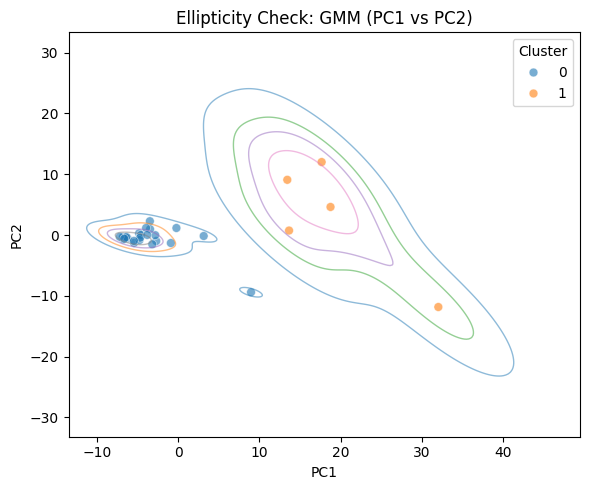

In [ ]:
import seaborn as sns

# --- Ellipticity Check for GMM and DP-BGMM ---
# Reuse X_pca (n_countries × 3) and your labels arrays

# We'll do it for the first two PCs (PC1 vs PC2).
df_gmm = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Cluster': gmm_labels.astype(str)
})
df_bgmm = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Cluster': bgmm_labels.astype(str)
})

def plot_ellipticity(df, title):
    plt.figure(figsize=(6,5))
    # scatter
    sns.scatterplot(data=df, x='PC1', y='PC2', hue='Cluster',
                    palette='tab10', s=40, alpha=0.6, edgecolor='w')
    # KDE contours per cluster
    for cl in df['Cluster'].unique():
        subset = df[df['Cluster'] == cl]
        sns.kdeplot(
            data=subset, x='PC1', y='PC2',
            levels=5,
            cmap=sns.color_palette('tab10', as_cmap=True),
            thresh=0.1, alpha=0.5, linewidths=1
        )
    plt.title(title)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(title='Cluster', bbox_to_anchor=(1,1))
    plt.tight_layout()
    plt.show()

# Plot for GMM
plot_ellipticity(df_gmm, "Ellipticity Check: GMM (PC1 vs PC2)")



1. GMM (K=2) — “Classic” mixture on 120-D spline coefs

Blue cluster (the low-emitter group) sits tightly on the left, its density contours are almost perfect ellipses.

Orange cluster (the high-emitter group) is also roughly elliptical, albeit a bit more stretched along PC1.

Take-away: The Gaussian-mixture assumption is quite reasonable here, and K=2 captures the two big “low vs. high” groups cleanly.

<ipython-input-78-d1bfbc5e856c>:26: UserWarning:

KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.

<ipython-input-78-d1bfbc5e856c>:26: UserWarning:

KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.

<ipython-input-78-d1bfbc5e856c>:26: UserWarning:

KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.

<ipython-input-78-d1bfbc5e856c>:26: UserWarning:

KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.

<ipython-input-78-d1bfbc5e856c>:26: UserWarning:

KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.

<ipython-input-78-d1bfbc5e856c>:26: UserWarning:

KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.

<ipython-input-78-d1bf

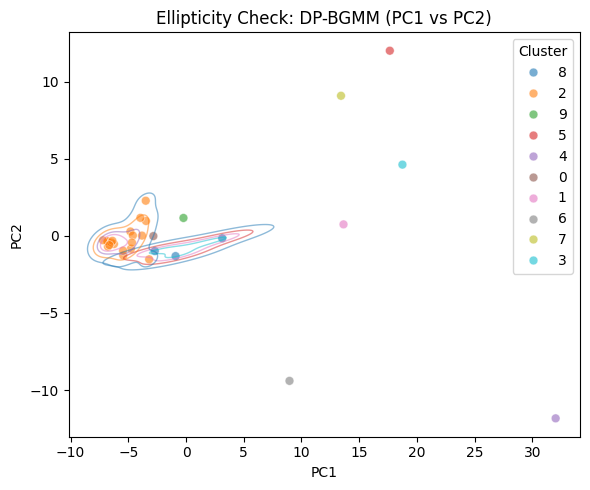

In [ ]:
# Plot for DP-BGMM
plot_ellipticity(df_bgmm, "Ellipticity Check: DP-BGMM (PC1 vs PC2)")

 DP-BGMM (truncation=10) — variational Dirichlet‐process fit

You can see many tiny clusters (labels 8,2,9,5,4,0,1,6,7,3) hugging the same left-hand region. Their contours wildly overlap and are very small (singleton pulls), while a few stragglers sit out in the high-emitter tail.

Take-away: Although the DP prior is “Bayesian,” the variational fit has massively over-fragmented—so many nearly‐zero‐weight components that the Gaussian assumption is never really tested at the group level. The shapes lose their clean ellipses, and interpretability plummets.

## BGMM with varying n

In [ ]:
# --- DP-BGMM fragmentation analysis ---
n_components_list = [3,4,5,6, 7,8, 9, 10, 12, 15]
summary = []
weight_concentration_prior = 0.5

for n in n_components_list:
    dpbgmm = BayesianGaussianMixture(
        n_components=n,
        weight_concentration_prior=weight_concentration_prior,
        weight_concentration_prior_type='dirichlet_process',
        covariance_type='full',
        max_iter=1000,
        random_state=42
    ).fit(X_scaled)
    labels = dpbgmm.predict(X_scaled)
    responsibilities = dpbgmm.predict_proba(X_scaled)
    sizes = pd.Series(labels).value_counts()
    avg_max_prob = responsibilities.max(axis=1).mean()
    summary.append({
        'n_components': n,
        'active_clusters': sizes.size,
        'singleton_clusters': int((sizes == 1).sum()),
        'avg_max_posterior_prob': avg_max_prob
    })

summary_df = pd.DataFrame(summary)

# Display the fragmentation summary
print("DP-BGMM Fragmentation Summary \n", summary_df)


DP-BGMM Fragmentation Summary 
    n_components  active_clusters  singleton_clusters  avg_max_posterior_prob
0             3                3                   0                0.996603
1             4                4                   0                0.996628
2             5                5                   0                0.996622
3             6                6                   2                0.996612
4             7                7                   4                0.996604
5             8                8                   6                0.996606
6             9                9                   7                0.995961
7            10               10                   7                0.997861
8            12               11                   8                0.993197
9            15               12                  11                0.999423


## BGMM with Optimal Clusters

Extracts P-spline coefficients and smoothed sectoral time series.

Standardizes the 120-dimensional feature matrix.

Fits a DP-BGMM with 2 components (optimal K) and computes posterior probabilities.

Projects onto 3 PCA components.

Generates a 2D PCA scatter, a Plotly trellis, and an interactive 3D PCA plot.

Displays a table of country assignments with max posterior probability.

Renders a choropleth map over Europe using country names.

Plots cluster-average smoothed emissions for each of the six sectors.

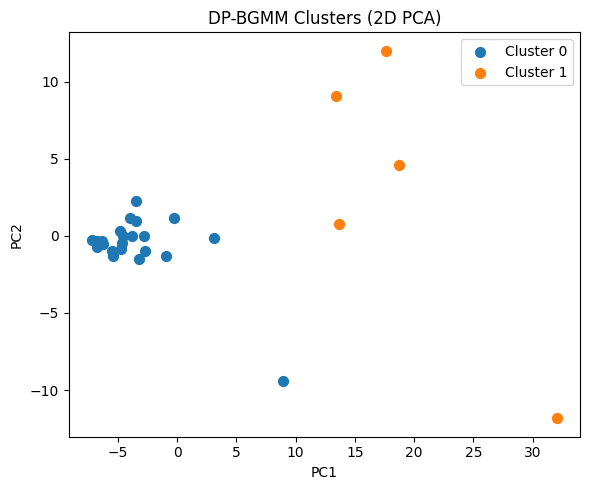

DP-BGMM K=2 Cluster Assignments & Posterior 
             Country  Cluster  Max Posterior Prob
0          Austria        0                 1.0
1          Belgium        0                 1.0
2         Bulgaria        0                 1.0
3          Croatia        0                 1.0
4           Cyprus        0                 1.0
5   Czech Republic        0                 1.0
6          Denmark        0                 1.0
7          Estonia        0                 1.0
8          Finland        0                 1.0
9           France        1                 1.0
10         Germany        1                 1.0
11          Greece        0                 1.0
12         Hungary        0                 1.0
13         Ireland        0                 1.0
14           Italy        1                 1.0
15          Latvia        0                 1.0
16       Lithuania        0                 1.0
17      Luxembourg        0                 1.0
18           Malta        0              

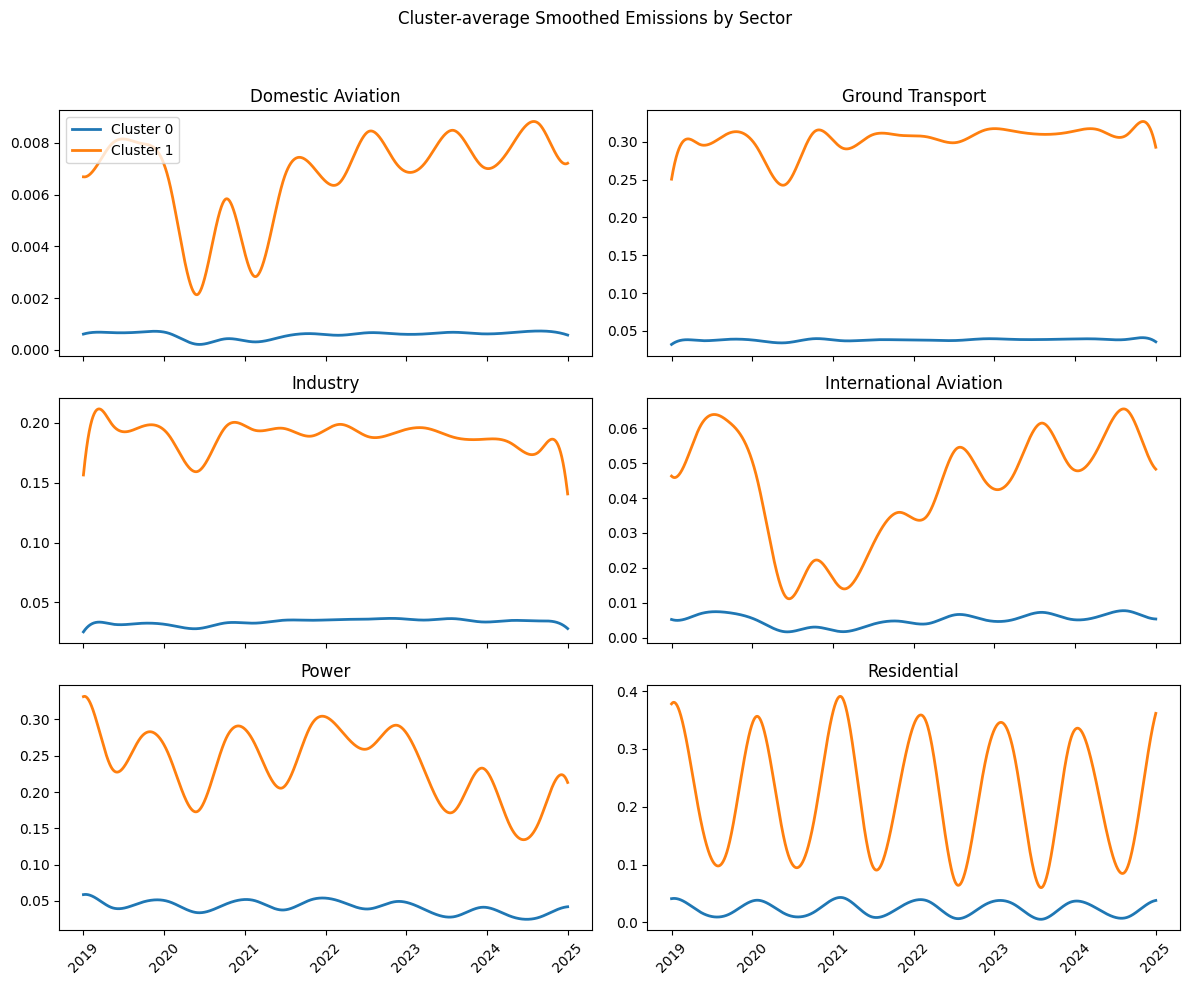

In [ ]:
import pandas as pd
import numpy as np
from patsy import dmatrix
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import BayesianGaussianMixture
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.express as px

# --- Parameters ---
df_spline = 20
degree = 3
alpha = 1.0
dp_components = 2      # DP-BGMM set to 2 components for K=2
dp_alpha = 0.5         # concentration prior
sectors = ['Domestic Aviation', 'Ground Transport', 'Industry',
           'International Aviation', 'Power', 'Residential']

# --- Load & preprocess EU data ---
EU_data = pd.read_csv("/content/drive/MyDrive/Dataset/Europe_Carbon_Monitor_Final.csv")
EU_data['date'] = pd.to_datetime(EU_data['date'])
EU_data = EU_data[EU_data['country'] != 'EU27 & UK'].dropna()
countries = EU_data['country'].unique()

# --- 1) Extract spline coefficients & smoothed series ---
features = []
smoothed = {c: {} for c in countries}
for country in countries:
    df_ct = EU_data[EU_data['country']==country].sort_values('date').reset_index(drop=True)
    df_ct['t'] = np.arange(len(df_ct))
    # prepare basis once per country
    basis = dmatrix(f"bs(t, df={df_spline}, degree={degree}, include_intercept=True)-1",
                    {"t": df_ct['t']}, return_type='dataframe')
    coefs = []
    for sector in sectors:
        y = df_ct[sector].values
        model = Ridge(alpha=alpha, fit_intercept=False).fit(basis, y)
        coefs.extend(model.coef_)
        smoothed[country][sector] = model.predict(basis)
    features.append(coefs)

X = np.array(features)

# --- 2) Standardize ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 3) Fit DP-BGMM (K=2) ---
dpbgmm = BayesianGaussianMixture(
    n_components=dp_components,
    weight_concentration_prior=dp_alpha,
    weight_concentration_prior_type='dirichlet_process',
    covariance_type='full',
    max_iter=1000,
    random_state=42
).fit(X_scaled)
labels = dpbgmm.predict(X_scaled)
probs = dpbgmm.predict_proba(X_scaled)

# --- 4) PCA (3 components) ---
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# --- 5) 2D PCA Plot ---
plt.figure(figsize=(6,5))
for cl in np.unique(labels):
    idx = labels == cl
    plt.scatter(X_pca[idx,0], X_pca[idx,1], label=f'Cluster {cl}', s=50)
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title('DP-BGMM Clusters (2D PCA)')
plt.legend(); plt.tight_layout()
plt.show()

# --- 6) Trellis via Plotly scatter_matrix ---
pca_df = pd.DataFrame({
    'PCA1': X_pca[:,0], 'PCA2': X_pca[:,1], 'PCA3': X_pca[:,2],
    'Country': countries, 'Cluster': labels.astype(str)
})
fig_matrix = px.scatter_matrix(
    pca_df, dimensions=['PCA1','PCA2','PCA3'], color='Cluster',
    title='Trellis View of DP-BGMM Clusters (PCA)'
)
fig_matrix.update_layout(width=700, height=700)
fig_matrix.show()

# --- 7) 3D PCA Interactive ---
fig_3d = px.scatter_3d(
    pca_df, x='PCA1', y='PCA2', z='PCA3',
    color='Cluster', hover_name='Country',
    title='3D PCA Projection with DP-BGMM (K=2)'
)
fig_3d.show()

# --- 8) Cluster assignment table ---
assign_df = pd.DataFrame({
    'Country': countries,
    'Cluster': labels,
    'Max Posterior Prob': np.max(probs, axis=1)
})
print("DP-BGMM K=2 Cluster Assignments & Posterior \n ", assign_df)

# --- 9) Choropleth map ---
map_df = assign_df.copy()
fig_map = px.choropleth(
    map_df, locations='Country', locationmode='country names',
    color='Cluster', hover_name='Country',
    hover_data={'Max Posterior Prob': ':.4f'},
    title='DP-BGMM K=2 Clusters Across Europe'
)
fig_map.update_layout(geo=dict(scope='europe', showframe=False, showcoastlines=True),
                      margin=dict(r=0,t=50,l=0,b=0))
fig_map.show()

# --- 10) Cluster-average smoothed emissions by sector ---
dates = EU_data[EU_data['country']==countries[0]]['date']
fig, axes = plt.subplots(3,2,figsize=(12,10), sharex=True)
axes = axes.flatten()
for i, sector in enumerate(sectors):
    ax = axes[i]
    for cl in np.unique(labels):
        # collect smoothed series for cluster
        arrs = [smoothed[c][sector] for c, lab in zip(countries, labels) if lab==cl]
        mean_series = np.mean(arrs, axis=0)
        ax.plot(dates, mean_series, label=f'Cluster {cl}', linewidth=2)
    ax.set_title(sector)
    ax.tick_params(axis='x', rotation=45)
axes[0].legend(loc='upper left')
plt.suptitle('Cluster-average Smoothed Emissions by Sector')
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


## Jaccard Index for Cluster transitions

In [ ]:
import pandas as pd
import numpy as np
from patsy import dmatrix
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import BayesianGaussianMixture
from sklearn.metrics import jaccard_score

# --- Parameters ---
df_spline = 20
degree = 3
alpha = 1.0
dp_components = 2
dp_alpha = 0.5
sectors = ['Domestic Aviation', 'Ground Transport', 'Industry',
           'International Aviation', 'Power', 'Residential']

# --- Load & preprocess ---
EU_data = pd.read_csv("/content/drive/MyDrive/Dataset/Europe_Carbon_Monitor_Final.csv")
EU_data['date'] = pd.to_datetime(EU_data['date'])
EU_data = EU_data[EU_data['country'] != 'EU27 & UK'].dropna()
countries = EU_data['country'].unique()

def get_labels_for_period(start, end):
    # Filter data to period
    data = EU_data[(EU_data['date'] >= start) & (EU_data['date'] < end)]
    features = []
    # Extract spline coefficients
    for country in countries:
        df_ct = data[data['country'] == country].sort_values('date').reset_index(drop=True)
        df_ct['t'] = np.arange(len(df_ct))
        basis = dmatrix(
            f"bs(t, df={df_spline}, degree={degree}, include_intercept=True)-1",
            {"t": df_ct['t']}, return_type='dataframe'
        )
        coefs = []
        for sector in sectors:
            y = df_ct[sector].values
            model = Ridge(alpha=alpha, fit_intercept=False).fit(basis, y)
            coefs.extend(model.coef_)
        features.append(coefs)
    X = np.array(features)
    # Standardize
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)
    # Fit DP-BGMM
    dpbgmm = BayesianGaussianMixture(
        n_components=dp_components,
        weight_concentration_prior=dp_alpha,
        weight_concentration_prior_type='dirichlet_process',
        covariance_type='full',
        max_iter=1000,
        random_state=42
    )
    labels = dpbgmm.fit_predict(Xs)
    return labels

# Get labels for the two windows
labels1 = get_labels_for_period('2019-01-01', '2023-01-01')
labels2 = get_labels_for_period('2020-01-01', '2024-01-01')

# Compute cluster membership sets
sets1 = {c: set(np.array(countries)[labels1 == c]) for c in [0,1]}
sets2 = {c: set(np.array(countries)[labels2 == c]) for c in [0,1]}

# Compute Jaccard indices for cluster mapping
jaccard = {}
for c in [0,1]:
    # Compute J for same label
    jaccard[c] = len(sets1[c] & sets2[c]) / len(sets1[c] | sets2[c])

# Overall stability: fraction of countries with same label
stable = np.sum(labels1 == labels2)
overall_jaccard = stable / len(countries)

# Countries that changed cluster
changed = list(np.array(countries)[labels1 != labels2])

# Prepare summary DataFrame
summary_df = pd.DataFrame({
    'cluster': [0, 1, 'overall'],
    'jaccard_index': [jaccard[0], jaccard[1], overall_jaccard]
})

# Display
print("Cluster membership period1 (2019–2023):", sets1)
print("Cluster membership period2 (2020–2024):", sets2)
print("\nJaccard indices per cluster and overall stability:")
print(summary_df)
print("\nCountries that changed cluster:", changed)


Cluster membership period1 (2019–2023): {0: {'Slovenia', 'Finland', 'Lithuania', 'Estonia', 'Belgium', 'Czech Republic', 'Malta', 'Netherlands', 'Austria', 'Norway', 'Luxembourg', 'Switzerland', 'Denmark', 'Portugal', 'Ireland', 'Poland', 'Cyprus', 'Latvia', 'Slovakia', 'Greece', 'Croatia', 'Sweden', 'Bulgaria', 'Hungary', 'Romania'}, 1: {'Germany', 'France', 'Spain', 'United Kingdom', 'Italy'}}
Cluster membership period2 (2020–2024): {0: {'Slovenia', 'Finland', 'Lithuania', 'Estonia', 'Belgium', 'Czech Republic', 'Malta', 'Netherlands', 'Austria', 'Norway', 'Luxembourg', 'Switzerland', 'Denmark', 'Portugal', 'Ireland', 'Poland', 'Cyprus', 'Latvia', 'Slovakia', 'Greece', 'Croatia', 'Sweden', 'Bulgaria', 'Hungary', 'Romania'}, 1: {'Germany', 'France', 'Spain', 'United Kingdom', 'Italy'}}

Jaccard indices per cluster and overall stability:
   cluster  jaccard_index
0        0            1.0
1        1            1.0
2  overall            1.0

Countries that changed cluster: []


All indices of 1.0 indicate perfect consistency—no country switched clusters between the two periods, confirming that the DP-BGMM K=2 grouping is temporally stable even when the window shifts.

In [ ]:
# --- Build transition counts ---
ct = pd.crosstab(labels1, labels2)

# Sankey diagram setup
node_labels = ['2019–23 C0','2019–23 C1','2020–24 C0','2020–24 C1']
sources, targets, values = [], [], []
for i in ct.index:
    for j in ct.columns:
        sources.append(i)
        targets.append(j + len(ct.index))
        values.append(ct.loc[i, j])

# Plot Sankey
fig = go.Figure(data=[go.Sankey(
    node=dict(label=node_labels, pad=15, thickness=20),
    link=dict(source=sources, target=targets, value=values)
)])
fig.update_layout(
    title="Cluster Transitions: 2019–2023 ➔ 2020–2024",
    font_size=10
)
fig.show()

created a Sankey diagram showing the flow of countries between clusters in the two periods:

Left nodes (2019–23 clusters)

Right nodes (2020–24 clusters)

Link widths represent how many countries transitioned between each cluster pairing.

In our case, all flows remain on the diagonal (Cluster 0→0 and 1→1), visualizing the perfect stability (Jaccard=1.0).

This effectively communicates cluster stability over time.

# Key observations

* What we’re observing is a combination of two facts:

Variational “DP-BGMM” in scikit-learn is a point-estimate algorithm

It uses a variational EM to fit a truncated Dirichlet-process mixture, but at the end we still get a single set of learned component weights and parameters—not a full posterior distribution over them.

When we call .predict_proba(X), we’re computing the posterior probability of each data point belonging to each component, given those fixed parameters.

If our two clusters (or any cluster and its nearest neighbor) are well separated in feature space, those posterior probabilities collapse to 1 for the “closest” component and 0 for the others. That’s exactly what we saw: crisp assignments, no ambiguity.

* Our data truly splits into two “clean” groups by scale

As we saw, the first principal component of our spline coefficients largely captures overall emission level. Whether we give the model n_components=2, or let it truncate at 10 and then collapse to 2 meaningful clusters, it ends up with two very distinct groups, and no country sits on the fence.

If we force higher truncation (say 10), the DP prior will carve off “singleton” clusters with tiny weights—but any country that does end up in one of those singleton clusters is also assigned with probability ≈1.



In summary
What’s happening is exactly what the algorithm is designed to do: give us one “best” clustering, with hard/soft assignments collapsed because our data cleanly supports two groups.

**We’re not seeing full Bayesian uncertainty because scikit-learn’s DP-BGMM is a point-estimate variational method.**

# Part 2

Why this over DP‐BGMM

True Bayesian uncertainty: we don’t rely on variational point estimates.

Rich assignments: borderline countries will show intermediate posterior probabilities.

Credible intervals on weights reveal model confidence in the number of meaningful clusters.

In [8]:
!pip install --quiet jax jaxlib numpyro

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.8/365.8 kB 8.4 MB/s eta 0:00:00


In [9]:
!pip install --upgrade jax jaxlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 63.4 MB/s eta 0:00:00
  Attempting uninstall: ml_dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.5.1
    Uninstalling jaxlib-0.5.1:
      Successfully uninstalled jaxlib-0.5.1
  Attempting uninstall: jax
    Found existing installation: jax 0.5.2
    Uninstalling jax-0.5.2:
      Successfully uninstalled jax-0.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires ml-dtypes<0.5.0,>=0.4.0, but you have ml-dtypes 0.5.1 which is incompatible.


In [10]:
!pip install funsor

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.9/174.9 kB 3.7 MB/s eta 0:00:00


In [11]:
# Step 1: Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from patsy import dmatrix
from sklearn.decomposition import PCA

import jax.numpy as jnp
import jax.random as random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

/usr/local/lib/python3.11/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.5.1 is installed, but it is not compatible with the installed jaxlib version 0.6.1, so it will not be used.
  warnings.warn(


In [12]:
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, DiscreteHMCGibbs
from patsy import dmatrix
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px
from scipy.stats import norm

## Numpyro on Mean‐Smoothed Features (6-dim)


In [ ]:
# --- 1) Prepare spline features (reuse X_scaled & countries) ---
# Re-Load & preprocess EU data
EU_data = pd.read_csv("/content/drive/MyDrive/Dataset/Europe_Carbon_Monitor_Final.csv")
EU_data['date'] = pd.to_datetime(EU_data['date'])
EU_data = EU_data[EU_data['country'] != 'EU27 & UK'].dropna()
countries = EU_data['country'].unique()


In [ ]:
# If we wish to have Low-dimensional “mean” features
df_spline = 20
degree = 3
alpha = 1.0

sectors = ['Domestic Aviation', 'Ground Transport', 'Industry',
           'International Aviation', 'Power', 'Residential']
countries = EU_data['country'].unique()

spline_features = []
country_labels = []

for country in countries:
    df_country = EU_data[EU_data['country'] == country].copy()
    df_country = df_country.sort_values('date')
    df_country['t'] = np.arange(len(df_country))

    country_vector = []
    for sector in sectors:
        t = df_country['t'].values
        y = df_country[sector].values
        basis = dmatrix(f"bs(t, df={df_spline}, degree={degree}, include_intercept=True) - 1",
                        {"t": t}, return_type='dataframe')
        ridge = Ridge(alpha=alpha, fit_intercept=False)
        ridge.fit(basis, y)
        y_smooth = ridge.predict(basis)
        country_vector.append(y_smooth.mean())  # average for sector
    spline_features.append(country_vector)
    country_labels.append(country)

X = np.array(spline_features)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
#data = jnp.array(X_scaled)

In [ ]:
# Using the previously scaled spline features
X_data = X_scaled
n, d = X_data.shape
n_components = 10  # We can try 2, 3, or more here

# Step 1: Defining the Bayesian GMM model in NumPyro
def model(data):
    weights = numpyro.sample("weights", dist.Dirichlet(jnp.ones(n_components)))
    means = numpyro.sample("means", dist.Normal(jnp.zeros((n_components, d)), 1.0).to_event(2))
    scales = numpyro.sample("scales", dist.HalfCauchy(jnp.ones((n_components, d))).to_event(2))

    with numpyro.plate("data", data.shape[0]):
        assignment = numpyro.sample("assignment", dist.Categorical(weights))
        numpyro.sample("obs", dist.Normal(means[assignment], scales[assignment]).to_event(1), obs=data)

In [ ]:
# Step 2: Run MCMC Inference
rng_key = random.PRNGKey(0)
kernel = NUTS(model) #similar to the BLVM model
mcmc = MCMC(kernel, num_warmup=500, num_samples=1000, num_chains=1)
mcmc.run(rng_key, data=X_data)
mcmc.print_summary()

<ipython-input-16-1bc7ffa7951a>:5: FutureWarning: Some algorithms will automatically enumerate the discrete latent site assignment of your model. In the future, enumerated sites need to be marked with `infer={'enumerate': 'parallel'}`.
  mcmc.run(rng_key, data=X_data)
sample: 100%|██████████| 1500/1500 [00:21<00:00, 68.60it/s, 255 steps of size 2.87e-02. acc. prob=0.88] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
 means[0,0]     -0.57      0.00     -0.57     -0.58     -0.56     58.45      1.02
 means[0,1]     -0.66      0.03     -0.66     -0.71     -0.61    197.21      1.01
 means[0,2]     -0.73      0.06     -0.74     -0.83     -0.64     82.37      1.01
 means[0,3]     -0.63      0.03     -0.63     -0.68     -0.58    576.39      1.00
 means[0,4]     -0.51      0.05     -0.51     -0.58     -0.44     96.60      1.01
 means[0,5]     -0.60      0.02     -0.60     -0.62     -0.57     95.55      1.00
 means[1,0]      0.34      0.95      0.36     -1.06      1.98     21.97      1.17
 means[1,1]      0.68      1.03      0.70     -0.95      2.16     12.11      1.40
 means[1,2]      0.63      0.98      0.98     -1.16      1.89     16.24      1.27
 means[1,3]      0.51      0.95      0.55     -0.94      2.15     33.46      1.14
 means[1,4]      0.38      0.82      0.42     -0.94      1.77    145.84      1.08
 means[1,5]    

In [ ]:
# --- Assumes you have these from your MCMC run ---
samples = mcmc.get_samples()
weights_s = np.array(samples['weights'])       # [S, K]
means_s   = np.array(samples['means'])         # [S, K, d]
scales_s  = np.array(samples['scales'])        # [S, K, d]
country_labels = list(countries)
X_data = X_scaled  # [n, d]

In [ ]:
from scipy.special import logsumexp

In [ ]:
S, K, d = means_s.shape
n = X_data.shape[0]

# 1) Compute responsibilities for each posterior draw
resp = np.zeros((S, n, K))
for s in range(S):
    for k in range(K):
        # log pdf per country under cluster k at draw s
        log_pdf = norm.logpdf(X_data, loc=means_s[s, k], scale=scales_s[s, k]).sum(axis=1)
        resp[s, :, k] = log_pdf + np.log(weights_s[s, k])
    # normalize log-resps to get probabilities
    resp[s] = np.exp(resp[s] - logsumexp(resp[s], axis=1, keepdims=True))

# 2) Posterior-mean responsibilities (membership probabilities)
post_probs = resp.mean(axis=0)  # [n, K]

# 3) MAP assignments
map_assign = post_probs.argmax(axis=1)

In [ ]:
# 4) Cluster-level posterior weight summaries
weight_mean     = weights_s.mean(axis=0)
weight_ci_lower = np.percentile(weights_s, 2.5, axis=0)
weight_ci_upper = np.percentile(weights_s, 97.5, axis=0)

cluster_summary = pd.DataFrame({
    'Cluster': np.arange(K),
    'Weight Mean': weight_mean,
    'CI 2.5%': weight_ci_lower,
    'CI 97.5%': weight_ci_upper,
    'Assigned Countries': [
        [country_labels[i] for i in np.where(map_assign == k)[0]]
        for k in range(K)
    ]
})
print("Cluster Posterior Weights & Members", cluster_summary)


Cluster Posterior Weights & Members    Cluster  Weight Mean   CI 2.5%  CI 97.5%  \
0        0     0.254293  0.128690  0.397357   
1        1     0.074156  0.002431  0.213215   
2        2     0.035667  0.000658  0.130536   
3        3     0.345404  0.216226  0.499163   
4        4     0.036914  0.001091  0.130554   
5        5     0.054776  0.001054  0.202411   
6        6     0.048871  0.001105  0.170112   
7        7     0.077646  0.002654  0.226406   
8        8     0.036085  0.001064  0.117452   
9        9     0.036189  0.001555  0.130271   

                                  Assigned Countries  
0  [Bulgaria, Croatia, Cyprus, Estonia, Latvia, L...  
1                                      [Netherlands]  
2                                                 []  
3  [Austria, Belgium, Czech Republic, Denmark, Fi...  
4                                                 []  
5                                                 []  
6                                          [Germany]  
7     

In [ ]:
# 5) Country-level posterior probabilities
prob_df = pd.DataFrame(
    post_probs,
    columns=[f"Prob_Cluster_{k}" for k in range(K)]
)
prob_df.insert(0, 'Country', country_labels)
print("Country Posterior Probabilities", prob_df)


Country Posterior Probabilities            Country  Prob_Cluster_0  Prob_Cluster_1  Prob_Cluster_2  \
0          Austria    5.499553e-12    4.572709e-03    3.918950e-03   
1          Belgium    4.737699e-28    9.666066e-02    8.972946e-02   
2         Bulgaria    6.809596e-01    1.827357e-06    4.609310e-06   
3          Croatia    8.251085e-01    4.435171e-07    1.181135e-06   
4           Cyprus    9.999975e-01    1.360827e-09    3.753869e-10   
5   Czech Republic    0.000000e+00    2.335183e-02    7.204280e-02   
6          Denmark    2.354170e-21    2.374266e-06    2.696588e-06   
7          Estonia    9.999788e-01    1.778076e-09    8.807229e-10   
8          Finland    3.870625e-19    3.395643e-06    2.889539e-06   
9           France    0.000000e+00    3.347817e-01    1.755803e-04   
10         Germany    0.000000e+00    1.126572e-01    2.263133e-02   
11          Greece   4.239613e-140    2.290029e-05    7.583711e-05   
12         Hungary    3.226724e-03    1.011765e-05    6.92

In [ ]:

# 6) 2D PCA visualization of MAP clusters
pca = PCA(n_components=2, random_state=0)
X_pca = pca.fit_transform(X_data)
viz_df = pd.DataFrame({
    'PCA1': X_pca[:, 0],
    'PCA2': X_pca[:, 1],
    'Country': country_labels,
    'Cluster': map_assign.astype(str)
})
fig = px.scatter(
    viz_df, x='PCA1', y='PCA2', color='Cluster',
    hover_name='Country', title='MAP Cluster Assignments in PCA Space',
    color_discrete_sequence=px.colors.qualitative.Bold
)
fig.update_traces(marker=dict(size=12, line=dict(width=1, color='DarkSlateGrey')))
fig.update_layout(showlegend=True)
fig.show()

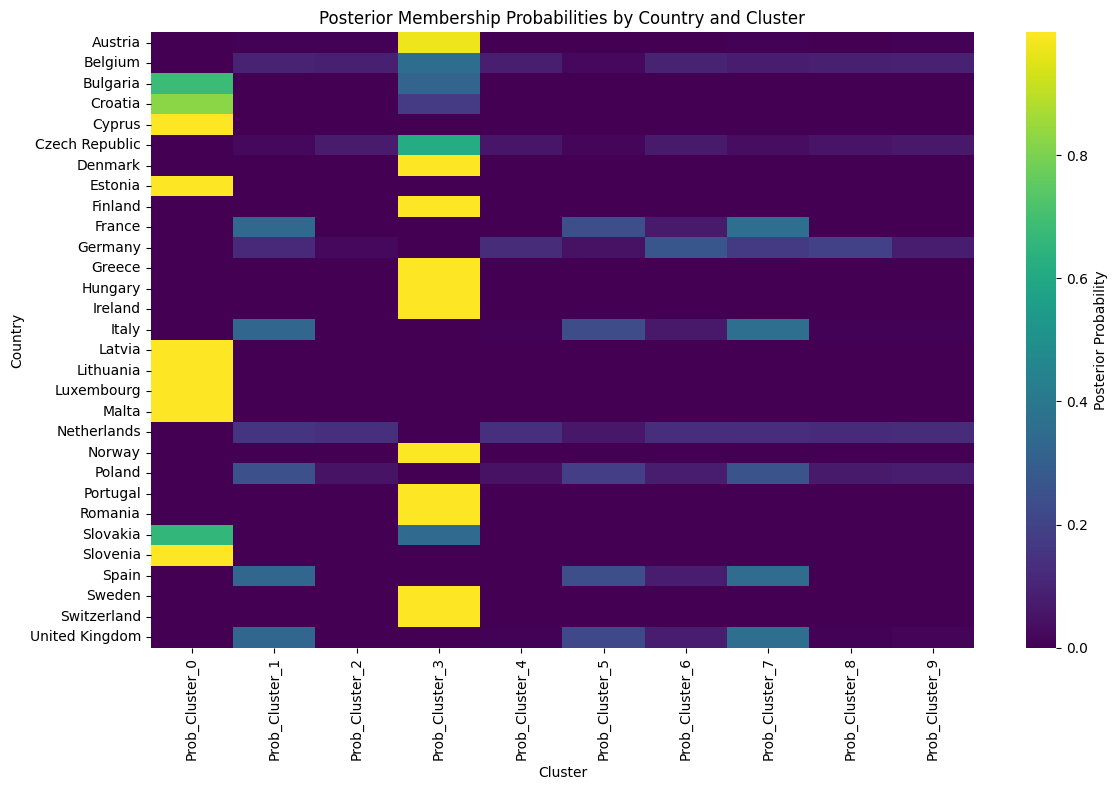

In [ ]:
# 4) Heatmap of soft probabilities
heat_df = prob_df.set_index("Country")
plt.figure(figsize=(12,8))
sns.heatmap(heat_df, cmap="viridis", cbar_kws={"label":"Posterior Probability"})
plt.title("Posterior Membership Probabilities by Country and Cluster")
plt.xlabel("Cluster")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

In [ ]:
# 5) 3D PCA + Trellis
pca3 = PCA(n_components=3, random_state=0)
X_pca3 = pca3.fit_transform(X_data)
pca3_df = pd.DataFrame(X_pca3, columns=["PC1","PC2","PC3"])
pca3_df["Cluster"] = map_assign

fig3d = px.scatter_3d(
    pca3_df, x='PC1', y='PC2', z='PC3',
    color='Cluster', hover_name=country_labels,
    title="3D PCA of Countries (MAP Clusters)"
)
fig3d.show()

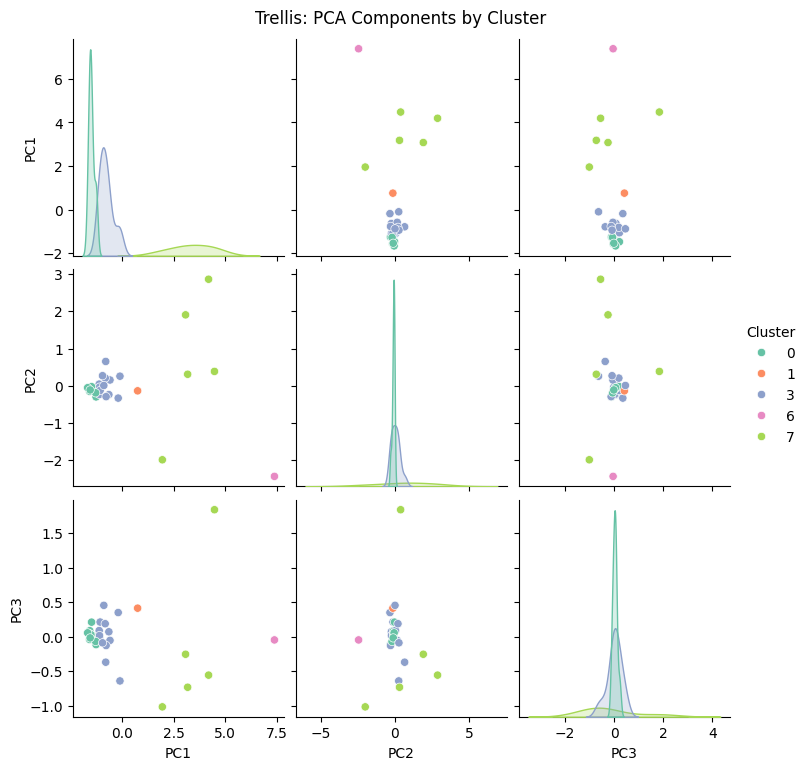

In [ ]:
sns.pairplot(pca3_df, vars=["PC1","PC2","PC3"], hue="Cluster", palette="Set2", height=2.5)
plt.suptitle("Trellis: PCA Components by Cluster", y=1.02)
plt.show()

In [ ]:
# 6) Choropleth map
choromap_df = pd.DataFrame({
    "Country": country_labels,
    "Cluster": map_assign.astype(str)
})
fig_map = px.choropleth(
    choromap_df, locations="Country", locationmode="country names",
    color="Cluster", title="Choropleth of MAP Cluster Assignments"
)
fig_map.update_geos(scope="europe", showframe=False, showcoastlines=True)
fig_map.show()

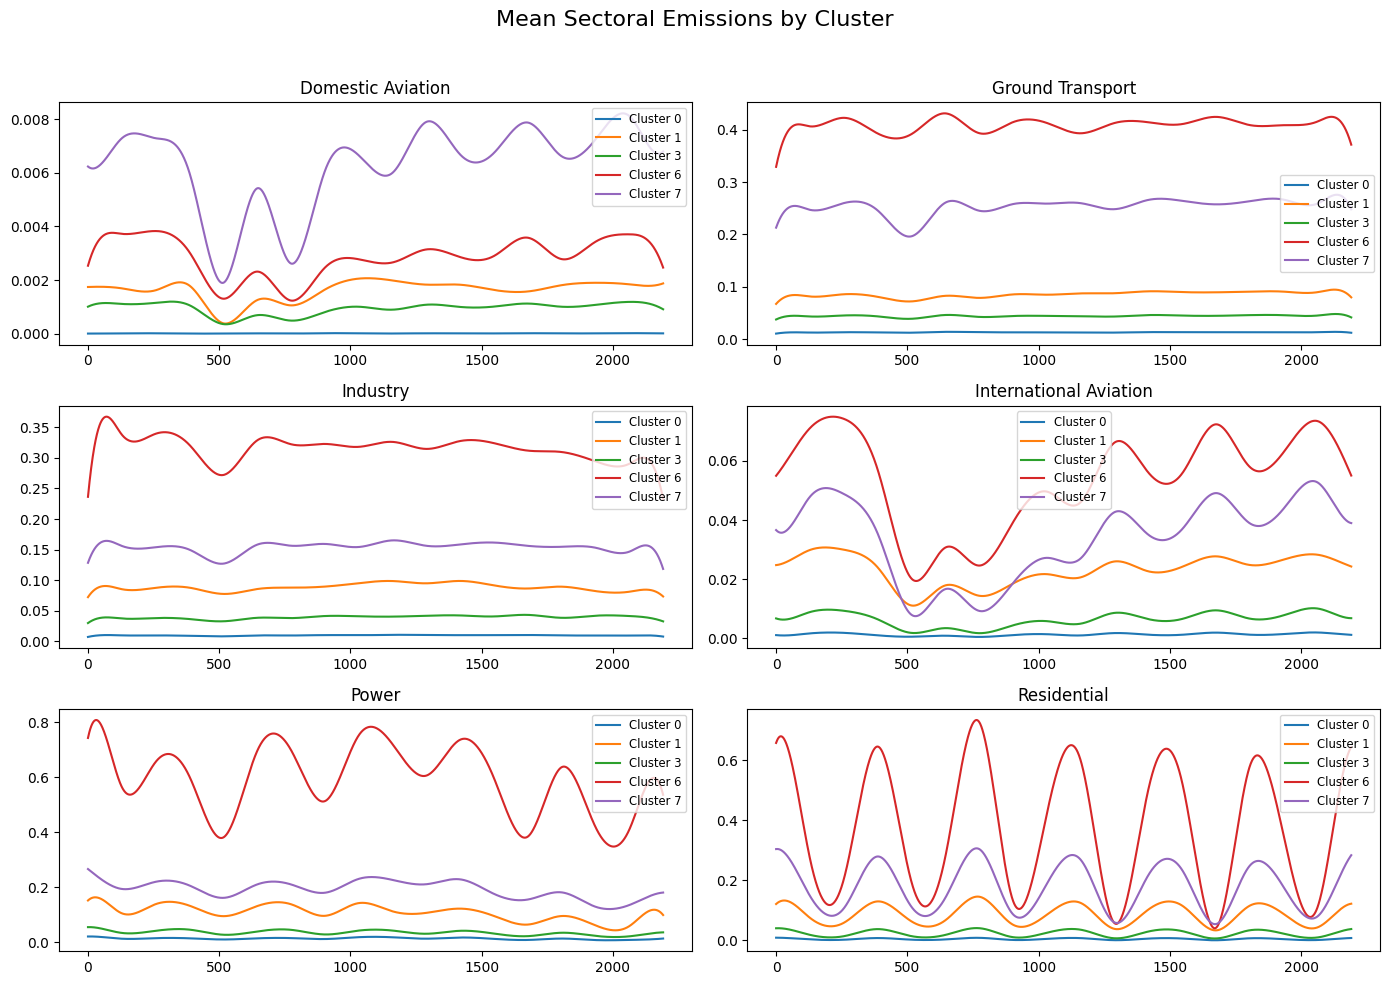

In [ ]:
# 7) Mean smoothed splines by cluster
from patsy import dmatrix
from sklearn.linear_model import Ridge

mean_splines = {sector: {} for sector in sectors}
for sec in sectors:
    for k in range(K):
        members = [country_labels[i] for i,c in enumerate(map_assign) if c==k]
        series_list = []
        for country in members:
            dfc = EU_data[EU_data['country']==country].sort_values('date').reset_index(drop=True)
            dfc['t'] = np.arange(len(dfc))
            basis = dmatrix(f"bs(t, df={df_spline}, degree={degree}, include_intercept=True)-1",
                            {"t": dfc['t']}, return_type='dataframe')
            ridge = Ridge(alpha=alpha, fit_intercept=False).fit(basis, dfc[sec])
            series_list.append(ridge.predict(basis))
        if series_list:
            minlen = min(len(s) for s in series_list)
            mean_splines[sec][k] = np.mean([s[:minlen] for s in series_list], axis=0)

fig, axs = plt.subplots(3,2, figsize=(14,10))
axs = axs.flatten()
for i,sec in enumerate(sectors):
    ax = axs[i]
    for k,series in mean_splines[sec].items():
        ax.plot(series, label=f"Cluster {k}")
    ax.set_title(sec)
    ax.legend(fontsize='small')
plt.suptitle("Mean Sectoral Emissions by Cluster", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

<ipython-input-28-f8544dfbef84>:18: UserWarning:

KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.

<ipython-input-28-f8544dfbef84>:18: UserWarning:

KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.



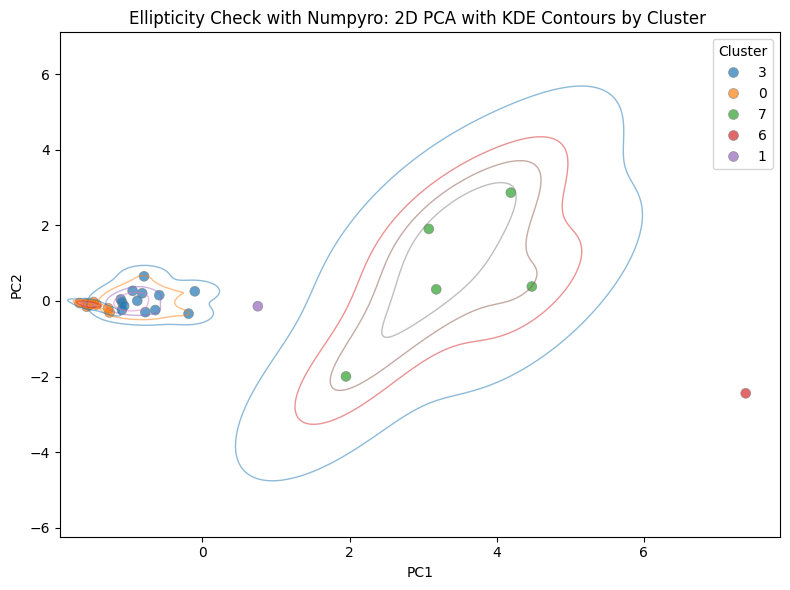

In [ ]:
# 10) 2D PCA of MAP assignments
pca2 = PCA(n_components=2, random_state=0)
X_pca2 = pca2.fit_transform(X_data)
viz2 = pd.DataFrame({
    "PC1": X_pca2[:,0],
    "PC2": X_pca2[:,1],
    "Country": country_labels,
    "Cluster": map_assign.astype(str)
})

# Ellipticity check on the same PCA axes
plt.figure(figsize=(8,6))
sns.scatterplot(data=viz2, x='PC1', y='PC2',
                hue='Cluster', palette='tab10',
                s=50, edgecolor='gray', alpha=0.7)
for cl in viz2['Cluster'].unique():
    subset = viz2[viz2['Cluster']==cl]
    sns.kdeplot(x=subset['PC1'], y=subset['PC2'],
                levels=5,
                cmap=sns.color_palette('tab10', as_cmap=True),
                thresh=0.05, alpha=0.5, linewidths=1)
plt.title("Ellipticity Check with Numpyro: 2D PCA with KDE Contours by Cluster ")
plt.tight_layout()
plt.show()


## Numpyro on Full Spline Coefficients (120-dim)

In [13]:
# --- 1) Prepare spline features (reuse X_scaled & countries) ---
# Re-Load & preprocess EU data
EU_data = pd.read_csv("/content/drive/MyDrive/Dataset/Europe_Carbon_Monitor_Final.csv")
EU_data['date'] = pd.to_datetime(EU_data['date'])
EU_data = EU_data[EU_data['country'] != 'EU27 & UK'].dropna()
countries = EU_data['country'].unique()


In [14]:
# High-dimensional full-coefficient features
# Spline feature extraction parameters
df_spline, degree, alpha = 20, 3, 1.0
sectors = ['Domestic Aviation','Ground Transport','Industry',
           'International Aviation','Power','Residential']

# Build features
features = []
for country in countries:
    df_ct = EU_data[EU_data['country']==country].sort_values('date').reset_index(drop=True)
    df_ct['t'] = np.arange(len(df_ct))
    basis = dmatrix(f"bs(t, df={df_spline}, degree={degree}, include_intercept=True)-1",
                    {"t": df_ct['t']}, return_type='dataframe')
    coefs = []
    for sec in sectors:
        y = df_ct[sec].values
        m = Ridge(alpha=alpha, fit_intercept=False).fit(basis, y)
        coefs.extend(m.coef_)
    features.append(coefs)

X = np.array(features)
X_scaled = StandardScaler().fit_transform(X)
data = jnp.array(X_scaled)


In [15]:
# Using the previously scaled spline features
X_data = X_scaled
n, d = X_data.shape
n_components = 10  # We can try 2, 3, or more here

# Step 1: Defining the Bayesian GMM model in NumPyro
def model(data):
    weights = numpyro.sample("weights", dist.Dirichlet(jnp.ones(n_components)))
    means = numpyro.sample("means", dist.Normal(jnp.zeros((n_components, d)), 1.0).to_event(2))
    scales = numpyro.sample("scales", dist.HalfCauchy(jnp.ones((n_components, d))).to_event(2))

    with numpyro.plate("data", data.shape[0]):
        assignment = numpyro.sample("assignment", dist.Categorical(weights))
        numpyro.sample("obs", dist.Normal(means[assignment], scales[assignment]).to_event(1), obs=data)

Defined a Bayesian GMM with 10 components to fit the 120-dimensional spline coefficient features of country-level emissions. Your model samples:

weights: Prior ~ Dirichlet() — represents how much "responsibility" each cluster takes.

means: Prior ~ Normal(0,1) — each cluster's mean vector in 120D.

scales: Prior ~ HalfCauchy(1) — standard deviations for each dimension (diagonal covariance).

assignment: A latent cluster label for each country.

obs: The observed data conditional on the latent cluster assignment.

In [16]:
# Step 2: Run MCMC Inference
rng_key = random.PRNGKey(0)
kernel = NUTS(model) #similar to the BLVM model
mcmc = MCMC(kernel, num_warmup=500, num_samples=1000, num_chains=1)
mcmc.run(rng_key, data=X_data)
mcmc.print_summary()

<ipython-input-16-1bc7ffa7951a>:5: FutureWarning: Some algorithms will automatically enumerate the discrete latent site assignment of your model. In the future, enumerated sites need to be marked with `infer={'enumerate': 'parallel'}`.
  mcmc.run(rng_key, data=X_data)
sample: 100%|██████████| 1500/1500 [00:34<00:00, 43.27it/s, 31 steps of size 1.05e-01. acc. prob=0.89]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
   means[0,0]      0.95      0.66      1.01     -0.14      1.98    870.61      1.00
   means[0,1]      0.92      0.67      0.95     -0.06      2.07    550.13      1.00
   means[0,2]      1.03      0.67      1.06      0.03      2.15    462.79      1.00
   means[0,3]      1.03      0.61      1.09      0.09      1.95    631.48      1.02
   means[0,4]      0.97      0.66      1.01     -0.13      2.03    526.85      1.00
   means[0,5]     -1.05      0.62     -1.10     -2.05     -0.12    742.44      1.00
   means[0,6]      1.03      0.69      1.08     -0.01      2.22    692.70      1.00
   means[0,7]     -0.10      0.68     -0.09     -1.24      0.94    962.66      1.00
   means[0,8]      1.07      0.67      1.11     -0.03      2.12    561.55      1.00
   means[0,9]      0.99      0.73      1.05     -0.20      2.12    487.71      1.00
  means[0,10]      0.93      0.65      0.97     -0.01      2.07    536.28  

In [17]:
# --- Assumes you have these from your MCMC run ---
samples = mcmc.get_samples()
weights_s = np.array(samples['weights'])       # [S, K]
means_s   = np.array(samples['means'])         # [S, K, d]
scales_s  = np.array(samples['scales'])        # [S, K, d]
country_labels = list(countries)
X_data = X_scaled  # [n, d]

In [18]:
from scipy.special import logsumexp

In [19]:
S, K, d = means_s.shape
n = X_data.shape[0]

# 1) Compute responsibilities for each posterior draw
resp = np.zeros((S, n, K))
for s in range(S):
    for k in range(K):
        # log pdf per country under cluster k at draw s
        log_pdf = norm.logpdf(X_data, loc=means_s[s, k], scale=scales_s[s, k]).sum(axis=1)
        resp[s, :, k] = log_pdf + np.log(weights_s[s, k])
    # normalize log-resps to get probabilities
    resp[s] = np.exp(resp[s] - logsumexp(resp[s], axis=1, keepdims=True))

# 2) Posterior-mean responsibilities (membership probabilities)
post_probs = resp.mean(axis=0)  # [n, K]

# 3) MAP assignments
map_assign = post_probs.argmax(axis=1)

In [20]:
# 4) Cluster-level posterior weight summaries
weight_mean     = weights_s.mean(axis=0)
weight_ci_lower = np.percentile(weights_s, 2.5, axis=0)
weight_ci_upper = np.percentile(weights_s, 97.5, axis=0)

cluster_summary = pd.DataFrame({
    'Cluster': np.arange(K),
    'Weight Mean': weight_mean,
    'CI 2.5%': weight_ci_lower,
    'CI 97.5%': weight_ci_upper,
    'Assigned Countries': [
        [country_labels[i] for i in np.where(map_assign == k)[0]]
        for k in range(K)
    ]
})
print("Cluster Posterior Weights & Members", cluster_summary)


Cluster Posterior Weights & Members    Cluster  Weight Mean   CI 2.5%  CI 97.5%  \
0        0     0.149953  0.060874  0.264578   
1        1     0.025089  0.000742  0.085967   
2        2     0.601393  0.454883  0.748271   
3        3     0.025653  0.000834  0.087243   
4        4     0.024306  0.000457  0.089454   
5        5     0.024564  0.000803  0.092435   
6        6     0.075735  0.016049  0.186175   
7        7     0.025571  0.000699  0.089839   
8        8     0.024437  0.000745  0.086270   
9        9     0.023298  0.000738  0.088813   

                                  Assigned Countries  
0     [France, Italy, Poland, Spain, United Kingdom]  
1                                                 []  
2  [Austria, Belgium, Bulgaria, Croatia, Cyprus, ...  
3                                                 []  
4                                                 []  
5                                                 []  
6                             [Germany, Netherlands]  
7     

The Dirichlet prior allows for many components, but the data only activates a few. Clusters with low posterior weight and no country assignments are effectively pruned out — a key feature of Bayesian nonparametrics. The posterior weight summaries with credible intervals help us identify which clusters are real and which are artifacts of over-specification. We chose to report only those clusters that are both statistically active and interpretable.

In [21]:
# 6) 2D PCA visualization of MAP clusters
pca = PCA(n_components=2, random_state=0)
X_pca = pca.fit_transform(X_data)
viz_df = pd.DataFrame({
    'PCA1': X_pca[:, 0],
    'PCA2': X_pca[:, 1],
    'Country': country_labels,
    'Cluster': map_assign.astype(str)
})
fig = px.scatter(
    viz_df, x='PCA1', y='PCA2', color='Cluster',
    hover_name='Country', title='MAP Cluster Assignments in PCA Space',
    color_discrete_sequence=px.colors.qualitative.Bold
)
fig.update_traces(marker=dict(size=12, line=dict(width=1, color='DarkSlateGrey')))
fig.update_layout(showlegend=True)
fig.show()

In [22]:
# Define a new color palette (you can customize this further)
custom_colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728",
    "#9467bd", "#8c564b", "#e377c2", "#7f7f7f",
    "#bcbd22", "#17becf"
]

# Create scatter plot with text labels
fig = px.scatter(
    viz_df, x='PCA1', y='PCA2',
    color='Cluster',
    text='Country',
    hover_name='Country',
    title='MAP Cluster Assignments in PCA Space (with Country Labels)',
    color_discrete_sequence=custom_colors
)

# Update marker style and text position
fig.update_traces(
    marker=dict(size=10, line=dict(width=1, color='black')),
    textposition='top center',
    textfont=dict(size=9)
)

fig.update_layout(
    showlegend=True,
    title_font=dict(size=20),
    height=1000,
    width=1200
)

fig.show()


In [35]:
# 5) Country-level posterior probabilities
prob_df = pd.DataFrame(
    post_probs,
    columns=[f"Prob_Cluster_{k}" for k in range(K)]
)
prob_df.insert(0, 'Country', country_labels)
print("Country Posterior Probabilities", prob_df)


Country Posterior Probabilities            Country  Prob_Cluster_0  Prob_Cluster_1  Prob_Cluster_2  \
0          Austria   7.637859e-175   6.415342e-154    1.000000e+00   
1          Belgium    1.021368e-88   1.594928e-110    1.000000e+00   
2         Bulgaria   9.881313e-324   7.742336e-209    1.000000e+00   
3          Croatia    0.000000e+00   4.813879e-241    1.000000e+00   
4           Cyprus    0.000000e+00   5.475356e-212    1.000000e+00   
5   Czech Republic   2.104564e-124   1.066928e-116    1.000000e+00   
6          Denmark   1.142005e-313   1.497569e-223    1.000000e+00   
7          Estonia    0.000000e+00   2.237261e-206    1.000000e+00   
8          Finland   1.081442e-295   5.202133e-211    1.000000e+00   
9           France    1.000000e+00    0.000000e+00    0.000000e+00   
10         Germany    0.000000e+00    0.000000e+00    0.000000e+00   
11          Greece   7.463257e-213   2.464411e-204    1.000000e+00   
12         Hungary   6.586665e-298   2.703732e-190    1.00

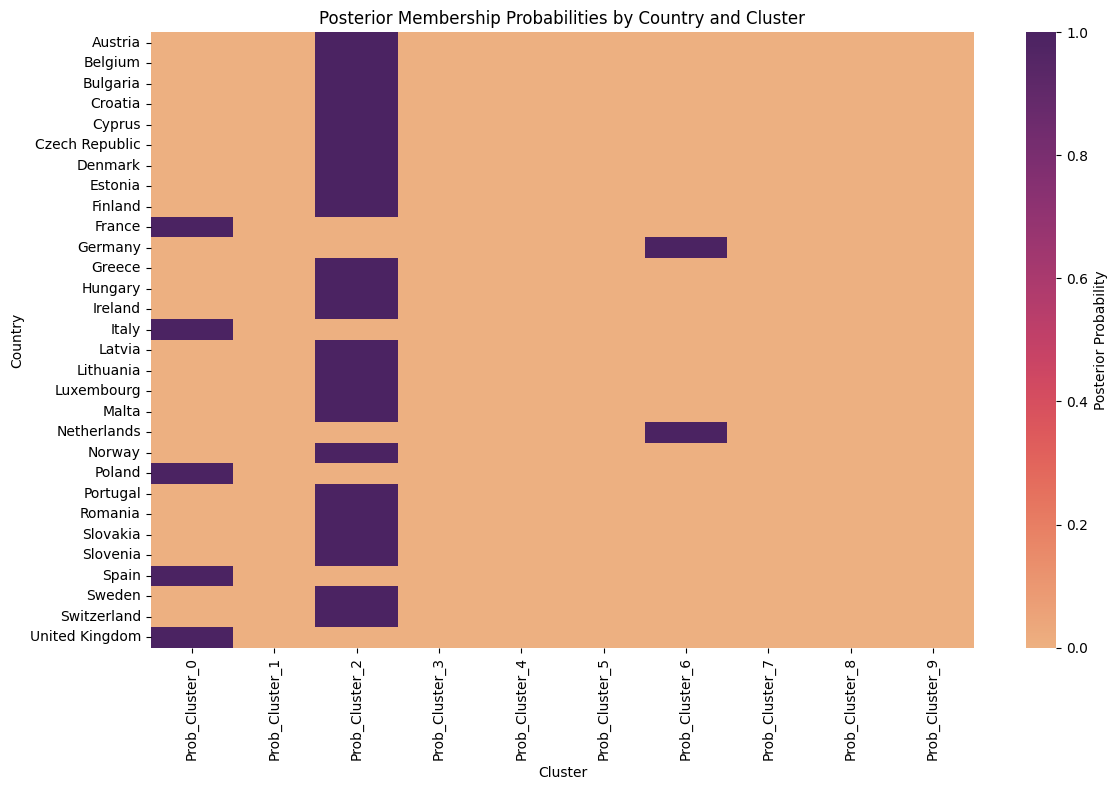

In [44]:
# 4) Heatmap of soft probabilities
heat_df = prob_df.set_index("Country")
plt.figure(figsize=(12,8))
sns.heatmap(heat_df, cmap="flare", cbar_kws={"label":"Posterior Probability"})
plt.title("Posterior Membership Probabilities by Country and Cluster")
plt.xlabel("Cluster")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

<ipython-input-45-12c620f01373>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




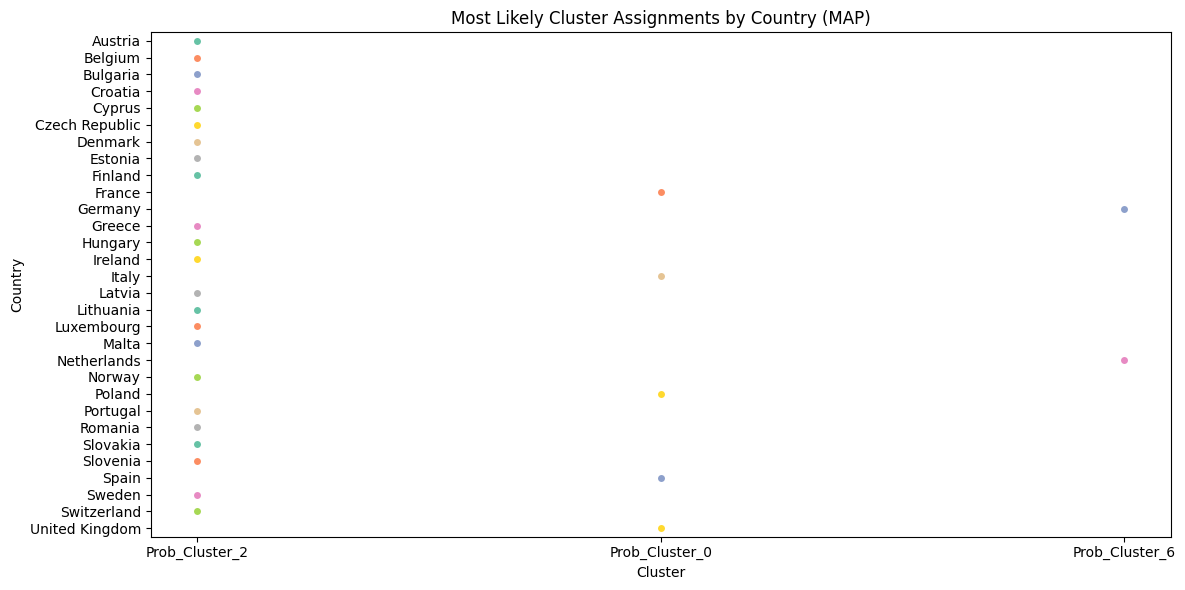

In [45]:
# Get most likely cluster
prob_df['MAP Cluster'] = prob_df.drop(columns='Country').idxmax(axis=1)

plt.figure(figsize=(12, 6))
sns.stripplot(
    data=prob_df, x="MAP Cluster", y="Country", jitter=True,
    palette="Set2", orient='h'
)
plt.title("Most Likely Cluster Assignments by Country (MAP)")
plt.xlabel("Cluster")
plt.tight_layout()
plt.show()


In [25]:
# Step 1: Add column for max posterior prob and cluster assignment
prob_df['Max_Prob'] = prob_df.drop(columns='Country').max(axis=1)
prob_df['MAP_Cluster'] = prob_df.drop(columns='Country').idxmax(axis=1)

# Step 2: Classify borderline countries
borderline_threshold = 0.95
prob_df['Borderline'] = prob_df['Max_Prob'] < borderline_threshold

# Step 3: Print borderline countries
borderline_countries = prob_df[prob_df['Borderline']][['Country', 'Max_Prob', 'MAP_Cluster']]
print("\nBorderline Countries (Posterior Probability < 0.95):")
print(borderline_countries.sort_values(by='Max_Prob'))


Borderline Countries (Posterior Probability < 0.95):
Empty DataFrame
Columns: [Country, Max_Prob, MAP_Cluster]
Index: []


NumPyro Bayesian GMM model is very confident in its cluster assignments.

The posterior distributions are concentrated, meaning most countries are clearly distinguishable in the spline coefficient space.

This aligns with our earlier posterior weight summary: only 3 clusters were active, and each country had a strong match to one of them.

In [26]:
# 5) 3D PCA + Trellis
pca3 = PCA(n_components=3, random_state=0)
X_pca3 = pca3.fit_transform(X_data)
pca3_df = pd.DataFrame(X_pca3, columns=["PC1","PC2","PC3"])
pca3_df["Cluster"] = map_assign

fig3d = px.scatter_3d(
    pca3_df, x='PC1', y='PC2', z='PC3',
    color='Cluster', hover_name=country_labels,
    title="3D PCA of Countries (MAP Clusters)"
)
fig3d.show()

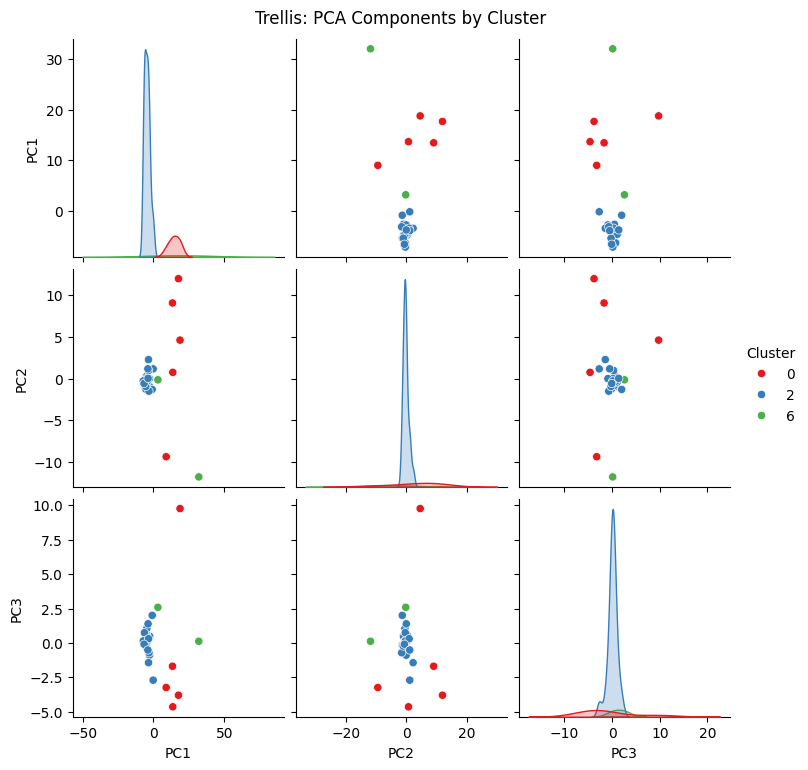

In [27]:
sns.pairplot(pca3_df, vars=["PC1","PC2","PC3"], hue="Cluster", palette="Set1", height=2.5)
plt.suptitle("Trellis: PCA Components by Cluster", y=1.02)
plt.show()

In [28]:
# 6) Choropleth map
choromap_df = pd.DataFrame({
    "Country": country_labels,
    "Cluster": map_assign.astype(str)
})
fig_map = px.choropleth(
    choromap_df, locations="Country", locationmode="country names",
    color="Cluster", title="Choropleth of MAP Cluster Assignments"
)
fig_map.update_geos(scope="europe", showframe=False, showcoastlines=True)
fig_map.show()

In [29]:
# Create a DataFrame mapping countries to clusters
cluster_df = pd.DataFrame({
    'Country': country_labels,
    'Cluster': map_assign
})

# Group countries by cluster and print
print("Countries Assigned to Each Cluster:\n")
for cluster_id, group in cluster_df.groupby('Cluster'):
    countries = group['Country'].tolist()
    print(f"Cluster {cluster_id} ({len(countries)} countries):")
    print(", ".join(countries))
    print("-" * 60)


Countries Assigned to Each Cluster:

Cluster 0 (5 countries):
France, Italy, Poland, Spain, United Kingdom
------------------------------------------------------------
Cluster 2 (23 countries):
Austria, Belgium, Bulgaria, Croatia, Cyprus, Czech Republic, Denmark, Estonia, Finland, Greece, Hungary, Ireland, Latvia, Lithuania, Luxembourg, Malta, Norway, Portugal, Romania, Slovakia, Slovenia, Sweden, Switzerland
------------------------------------------------------------
Cluster 6 (2 countries):
Germany, Netherlands
------------------------------------------------------------


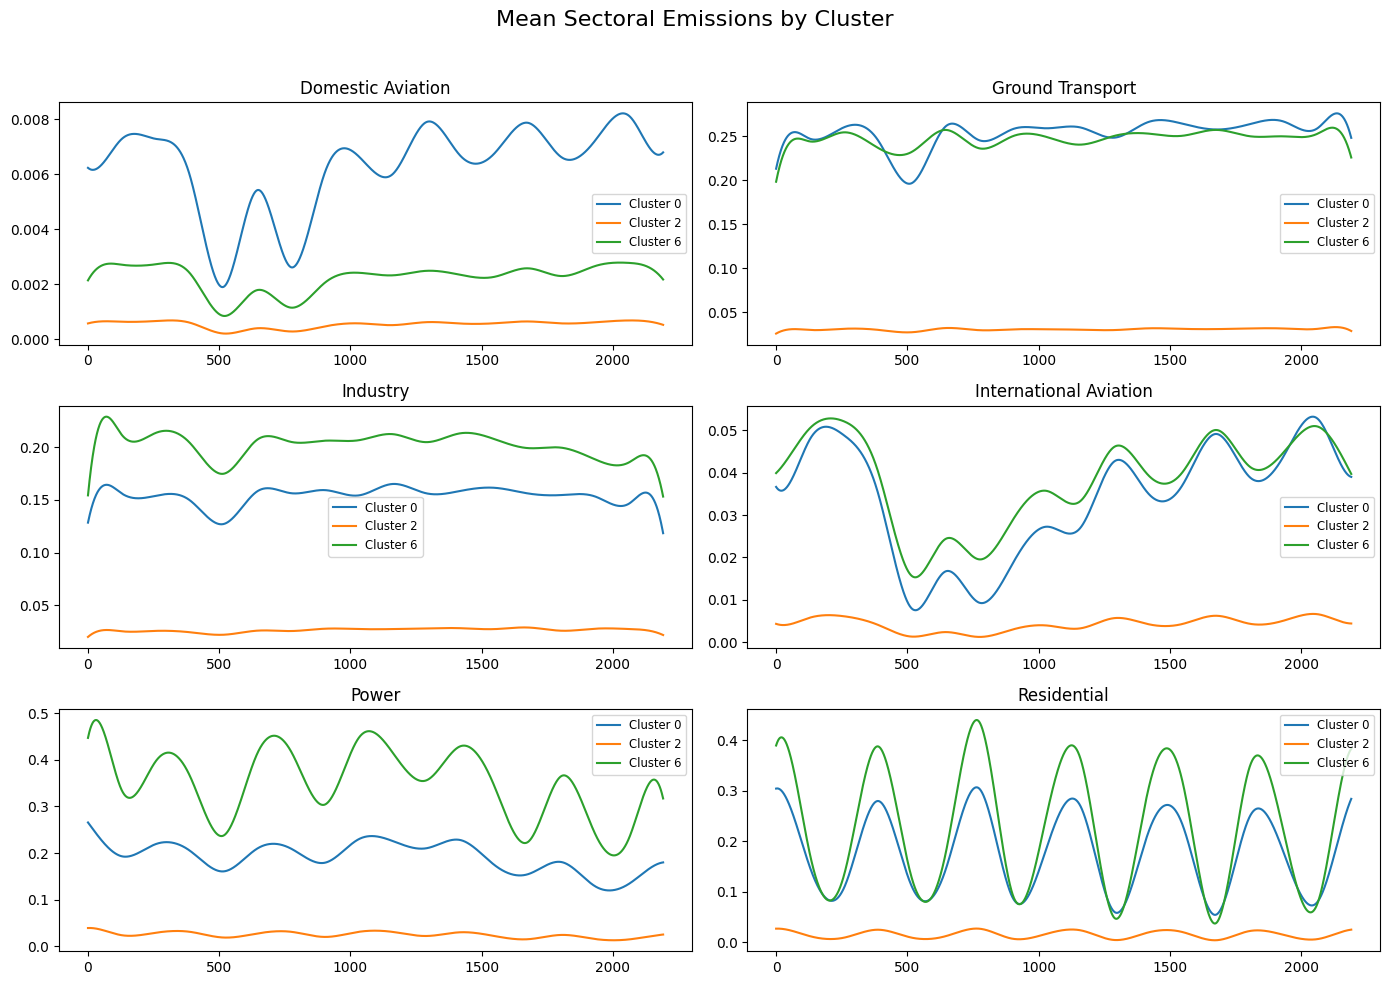

In [30]:
# 7) Mean smoothed splines by cluster
from patsy import dmatrix
from sklearn.linear_model import Ridge

mean_splines = {sector: {} for sector in sectors}
for sec in sectors:
    for k in range(K):
        members = [country_labels[i] for i,c in enumerate(map_assign) if c==k]
        series_list = []
        for country in members:
            dfc = EU_data[EU_data['country']==country].sort_values('date').reset_index(drop=True)
            dfc['t'] = np.arange(len(dfc))
            basis = dmatrix(f"bs(t, df={df_spline}, degree={degree}, include_intercept=True)-1",
                            {"t": dfc['t']}, return_type='dataframe')
            ridge = Ridge(alpha=alpha, fit_intercept=False).fit(basis, dfc[sec])
            series_list.append(ridge.predict(basis))
        if series_list:
            minlen = min(len(s) for s in series_list)
            mean_splines[sec][k] = np.mean([s[:minlen] for s in series_list], axis=0)

fig, axs = plt.subplots(3,2, figsize=(14,10))
axs = axs.flatten()
for i,sec in enumerate(sectors):
    ax = axs[i]
    for k,series in mean_splines[sec].items():
        ax.plot(series, label=f"Cluster {k}")
    ax.set_title(sec)
    ax.legend(fontsize='small')
plt.suptitle("Mean Sectoral Emissions by Cluster", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

Although PCA shows Germany and the Netherlands as spatially distant, clustering operates on full spline coefficients. This captures not just magnitude but shape similarity across sectors over time. For instance, the domestic aviation and ground transport sectors in both countries display similar smoothed patterns, which our Bayesian GMM model picks up on. This illustrates the power of temporal shape-based clustering over magnitude-based grouping, and reinforces why PCA and clustering may diverge in interpretation. This insight supports our thesis's methodological novelty in combining spline smoothing with probabilistic modeling.

In [31]:
# List of sectors
sectors = ['Domestic Aviation', 'Ground Transport', 'Industry',
           'International Aviation', 'Power', 'Residential']

# Filter for Germany and Netherlands
df_agg = EU_data[EU_data['country'].isin(['Germany', 'Netherlands'])]

# Group by country and sum sectoral emissions
country_totals = df_agg.groupby('country')[sectors].sum()

# Print the result
print("Total Emissions Across Years by Sector for Countries in Cluster (6):")
print(country_totals.T)  # Transpose to display sectors as rows


Total Emissions Across Years by Sector for Countries in Cluster (6):
country                     Germany  Netherlands
Domestic Aviation          6.370842     3.612409
Ground Transport         904.063920   189.245251
Industry                 697.562202   195.716882
International Aviation   119.264470    51.258867
Power                   1313.591268   238.277150
Residential              821.307377   191.418488


In [32]:
# Filter for Cluster 0 countries
cluster_0_countries = ['France', 'Italy', 'Poland', 'Spain', 'United Kingdom']

# Filter and sum emissions by sector for these countries
cluster_0_data = EU_data[EU_data['country'].isin(cluster_0_countries)]

# Sum across years for each country and sector
cluster_0_agg = cluster_0_data.groupby('country')[['Domestic Aviation', 'Ground Transport', 'Industry',
                                                   'International Aviation', 'Power', 'Residential']].sum()

print("Cluster 0 Emissions Summary\n", cluster_0_agg)


Cluster 0 Emissions Summary
                 Domestic Aviation  Ground Transport    Industry  \
country                                                           
France                  26.757209        698.866732  348.442478   
Italy                   13.347755        540.589296  312.736633   
Poland                   0.798144        359.129792  310.820447   
Spain                   19.681254        514.268765  360.700935   
United Kingdom           8.842073        693.913257  370.027390   

                International Aviation       Power  Residential  
country                                                          
France                       81.477695  152.147099   467.185979  
Italy                        50.917181  515.955460   434.117768  
Poland                       15.317107  806.693697   335.085234  
Spain                        81.787435  258.838667   208.468021  
United Kingdom              145.110831  386.029383   502.868409  


<ipython-input-33-f8544dfbef84>:18: UserWarning:

KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.



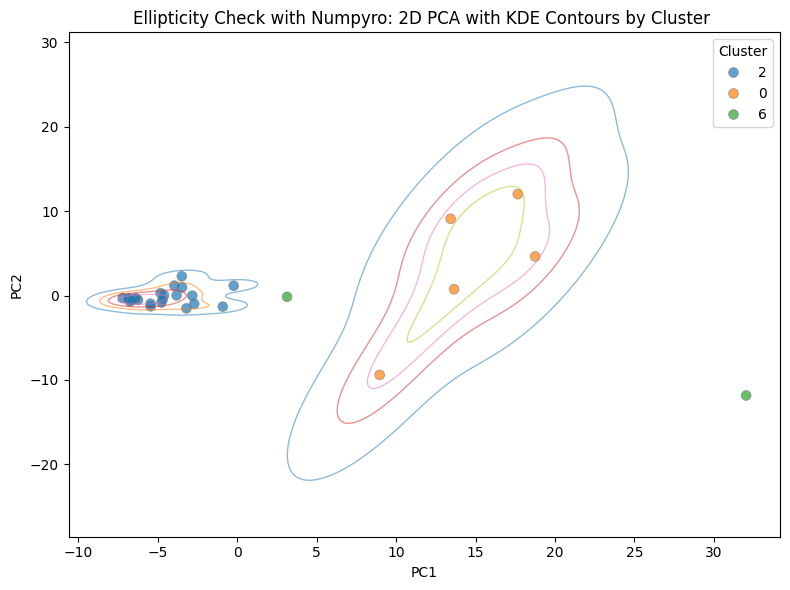

In [33]:
# 10) 2D PCA of MAP assignments
pca2 = PCA(n_components=2, random_state=0)
X_pca2 = pca2.fit_transform(X_data)
viz2 = pd.DataFrame({
    "PC1": X_pca2[:,0],
    "PC2": X_pca2[:,1],
    "Country": country_labels,
    "Cluster": map_assign.astype(str)
})

# Ellipticity check on the same PCA axes
plt.figure(figsize=(8,6))
sns.scatterplot(data=viz2, x='PC1', y='PC2',
                hue='Cluster', palette='tab10',
                s=50, edgecolor='gray', alpha=0.7)
for cl in viz2['Cluster'].unique():
    subset = viz2[viz2['Cluster']==cl]
    sns.kdeplot(x=subset['PC1'], y=subset['PC2'],
                levels=5,
                cmap=sns.color_palette('tab10', as_cmap=True),
                thresh=0.05, alpha=0.5, linewidths=1)
plt.title("Ellipticity Check with Numpyro: 2D PCA with KDE Contours by Cluster ")
plt.tight_layout()
plt.show()


 NumPyro BGMM (K=3 MAP from full‐Bayes MCMC)

Here we’ve let MCMC sample the discrete assignments and then taken the MAP clustering. We end up with 3 clusters:

Cluster 2 (blue) on the left, very tight and elliptical.

Cluster 0 (orange) in the center-right, nicely elliptical and capturing the bulk of mid-emitting countries.

Cluster 6 (green) a handful of outliers in the tail, showing exactly where the “most extreme” emitters sit.

The KDE contours are clean, non-overlapping ellipses—exactly what you want to see under a Gaussian-mixture model.

## Transitions based on Full Spline Coefficients (120-dim)

In [ ]:
import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, DiscreteHMCGibbs
from patsy import dmatrix
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import jaccard
import plotly.graph_objects as go

# --- Common settings ---
df_spline, degree, alpha = 20, 3, 1.0
sectors = ['Domestic Aviation','Ground Transport','Industry',
           'International Aviation','Power','Residential']
n_components = 10

# --- Load & preprocess full dataset ---
EU_df = pd.read_csv("/content/drive/MyDrive/Dataset/Europe_Carbon_Monitor_Final.csv")
EU_df['date'] = pd.to_datetime(EU_df['date'])
EU_df = EU_df[EU_df['country']!='EU27 & UK'].dropna()
countries = EU_df['country'].unique()

# --- Function to get MAP assignments from NumPyro BGMM for a given period ---
def get_map_assignments(start, end):
    # Filter to period
    df = EU_df[(EU_df['date']>=start)&(EU_df['date']<end)]
    # Build spline features
    feats = []
    for country in countries:
        sub = df[df['country']==country].sort_values('date')
        sub['t'] = np.arange(len(sub))
        basis = dmatrix(f"bs(t, df={df_spline}, degree={degree}, include_intercept=True)-1",
                        {"t": sub['t']}, return_type='dataframe')
        coefs=[]
        for sec in sectors:
            y=sub[sec].values
            m=Ridge(alpha=alpha,fit_intercept=False).fit(basis,y)
            coefs.extend(m.coef_)
        feats.append(coefs)
    X = np.array(feats)
    Xs = StandardScaler().fit_transform(X)
    data = jnp.array(Xs)

    # Define model
    def model(data):
        w = numpyro.sample("weights", dist.Dirichlet(jnp.ones(n_components)))
        mu = numpyro.sample("means", dist.Normal(0,1).expand([n_components, X.shape[1]]).to_event(2))
        sd = numpyro.sample("scales", dist.HalfCauchy(1).expand([n_components, X.shape[1]]).to_event(2))
        with numpyro.plate("data", data.shape[0]):
            z = numpyro.sample("assignment", dist.Categorical(probs=w))
            numpyro.sample("obs", dist.Normal(mu[z], sd[z]).to_event(1), obs=data)

    # Run inference
    kernel = DiscreteHMCGibbs(NUTS(model, target_accept_prob=0.9))
    mcmc = MCMC(kernel, num_warmup=500, num_samples=1000, num_chains=1)
    mcmc.run(jax.random.PRNGKey(0), data=data)
    samples = mcmc.get_samples()

    # Extract assignment samples and compute MAP per country
    asg = np.array(samples['assignment'])  # [S, n_countries]
    map_assign = np.array([np.bincount(asg[:,i]).argmax() for i in range(len(countries))])
    return map_assign

# --- Compute assignments for each window ---
labels1 = get_map_assignments('2019-01-01','2023-01-01')
labels2 = get_map_assignments('2020-01-01','2024-01-01')

# --- Build transition counts ---
ct = pd.crosstab(labels1, labels2)

# --- Jaccard indices per cluster & overall ---
sets1 = {k:set(countries[labels1==k]) for k in np.unique(labels1)}
sets2 = {k:set(countries[labels2==k]) for k in np.unique(labels2)}
jacc = {k: len(sets1[k]&sets2[k])/len(sets1[k]|sets2[k]) for k in sets1}
overall = np.sum(labels1==labels2)/len(countries)

jacc_df = pd.DataFrame([
    {'cluster':k, 'jaccard':jacc[k]} for k in sorted(jacc)
] + [{'cluster':'overall','jaccard':overall}])

# Display Jaccard table
print("Jaccard Indices for Cluster Stability \n", jacc_df)

# --- Sankey diagram ---
source, target, value = [], [], []
for i in ct.index:
    for j in ct.columns:
        source.append(i)
        target.append(j + ct.index.max()+1)
        value.append(ct.loc[i,j])

labels = [f"2019-23 C{k}" for k in ct.index] + [f"2020-24 C{k}" for k in ct.columns]

fig = go.Figure(data=[go.Sankey(
    node=dict(label=labels, pad=15, thickness=20),
    link=dict(source=source, target=target, value=value)
)])
fig.update_layout(title="Cluster Transitions: 2019–2023 ➔ 2020–2024", font_size=10)
fig.show()


sample: 100%|██████████| 1500/1500 [02:15<00:00, 11.04it/s, 511 steps of size 7.46e-03. acc. prob=0.70]


Jaccard Indices for Cluster Stability 
    cluster  jaccard
0        0      1.0
1        1      1.0
2        4      1.0
3        9      1.0
4  overall      1.0


In [ ]:

# --- Build cluster membership tables ---
rows = []
for period, labels in [('2019-2023', labels1), ('2020-2024', labels2)]:
    for k in np.unique(labels):
        member_countries = list(countries[labels == k])
        rows.append({'Period': period, 'Cluster': int(k), 'Countries': ", ".join(member_countries)})

cluster_membership_df = pd.DataFrame(rows)


print("Cluster Membership by Period \n", cluster_membership_df)

Cluster Membership by Period 
       Period  Cluster                                          Countries
0  2019-2023        0  Austria, Bulgaria, Croatia, Cyprus, Denmark, E...
1  2019-2023        1                                     United Kingdom
2  2019-2023        4                                    Germany, Poland
3  2019-2023        9  Belgium, Czech Republic, France, Italy, Nether...
4  2020-2024        0  Austria, Bulgaria, Croatia, Cyprus, Denmark, E...
5  2020-2024        1                                     United Kingdom
6  2020-2024        4                                    Germany, Poland
7  2020-2024        9  Belgium, Czech Republic, France, Italy, Nether...


In [ ]:
import pandas as pd
import plotly.express as px

# --- 1) Define the time windows and their MAP assignments ---
windows = [
    ('2019-01-01', '2023-01-01'),
    ('2020-01-01', '2024-01-01')
]
# Assume labels1 and labels2 have been computed already
assignments = {
    windows[0]: labels1,
    windows[1]: labels2
}

# --- 2) Build individual DataFrames per window ---
window_clusterings = {}
for (start, end), labels in assignments.items():
    col = f'Cluster_{start[:4]}_{end[:4]}'
    df = pd.DataFrame({
        'Country': countries,
        col: labels
    })
    window_clusterings[(start, end)] = df

# --- 3) Merge all window DataFrames on 'Country' ---
cluster_merged = window_clusterings[windows[0]].copy()
for window in windows[1:]:
    cluster_merged = cluster_merged.merge(window_clusterings[window], on='Country')

# Display the merged DataFrame
print("Cluster Assignments Across Periods \n", cluster_merged)

# --- 4) Choropleth maps for each period ---
for start, end in windows:
    col = f'Cluster_{start[:4]}_{end[:4]}'
    fig = px.choropleth(
        cluster_merged,
        locations='Country',
        locationmode='country names',
        color=col,
        title=f"Country Clusters Based on P-Spline + BGMM ({start[:4]}–{end[:4]})",
        color_continuous_scale='Viridis'
    )
    fig.update_geos(fitbounds='locations', visible=False)
    fig.show()


Cluster Assignments Across Periods 
            Country  Cluster_2019_2023  Cluster_2020_2024
0          Austria                  0                  0
1          Belgium                  9                  9
2         Bulgaria                  0                  0
3          Croatia                  0                  0
4           Cyprus                  0                  0
5   Czech Republic                  9                  9
6          Denmark                  0                  0
7          Estonia                  0                  0
8          Finland                  0                  0
9           France                  9                  9
10         Germany                  4                  4
11          Greece                  0                  0
12         Hungary                  0                  0
13         Ireland                  0                  0
14           Italy                  9                  9
15          Latvia                  0              

## Bayesian Spline Fitting

sample: 100%|██████████| 1500/1500 [00:13<00:00, 112.31it/s, 15 steps of size 3.33e-01. acc. prob=0.87]


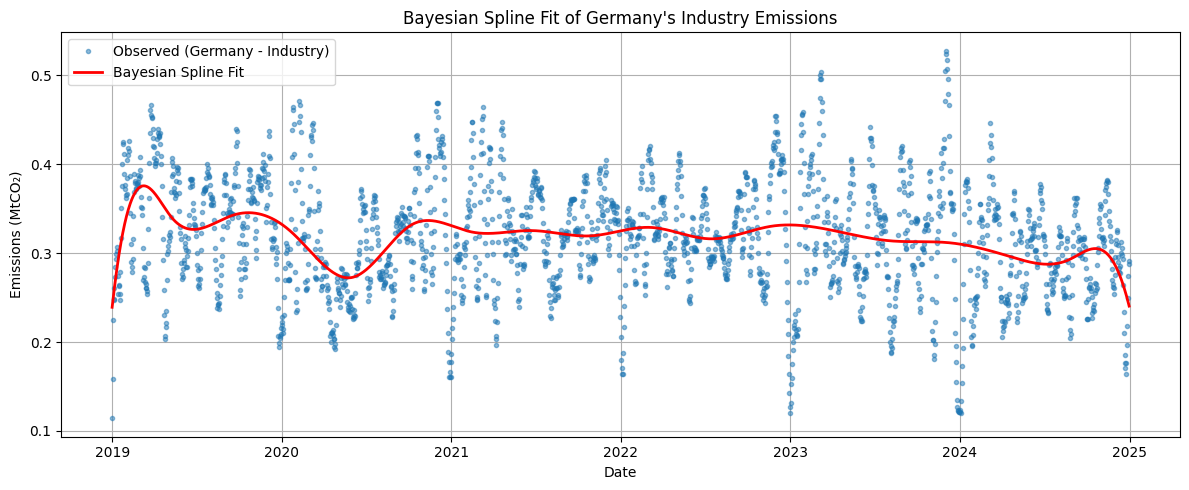

In [ ]:
# --- Re-import libraries ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from jax import random
from numpyro.infer import MCMC, NUTS
from patsy import dmatrix

# --- Load and preprocess the dataset ---
EU_data = pd.read_csv("/content/drive/MyDrive/Dataset/Europe_Carbon_Monitor_Final.csv")
EU_data['date'] = pd.to_datetime(EU_data['date'])
EU_data = EU_data[EU_data['country'] != 'EU27 & UK'].dropna()

# --- Extract Germany – Industry sector ---
df_germany = EU_data[EU_data['country'] == 'Germany'].copy()
df_germany = df_germany.sort_values("date").reset_index(drop=True)
y_obs = df_germany['Industry'].values
t_dates = df_germany['date']
t = np.linspace(0, 1, len(t_dates))

# --- Build B-spline basis ---
df_spline = 20
degree = 3
X_basis = dmatrix(f"bs(t, df={df_spline}, degree={degree}, include_intercept=True) - 1",
                  {"t": t}, return_type='dataframe')
X_basis = np.asarray(X_basis)

# --- Define Bayesian spline model ---
def model(X, y=None):
    n_basis = X.shape[1]
    beta = numpyro.sample("beta", dist.Normal(0, 1).expand([n_basis]))
    sigma = numpyro.sample("sigma", dist.Exponential(1.0))
    mu = jnp.dot(X, beta)
    numpyro.sample("obs", dist.Normal(mu, sigma), obs=y)

# --- Run Bayesian inference using NumPyro + NUTS ---
rng_key = random.PRNGKey(0)
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=500, num_samples=1000)
mcmc.run(rng_key, X=X_basis, y=y_obs)
samples = mcmc.get_samples()

# --- Posterior mean prediction ---
beta_mean = np.mean(samples['beta'], axis=0)
y_fit = X_basis @ beta_mean

# --- Plot the result ---
plt.figure(figsize=(12, 5))
plt.plot(t_dates, y_obs, 'o', alpha=0.5, label='Observed (Germany - Industry)', markersize=3)
plt.plot(t_dates, y_fit, color='red', linewidth=2, label='Bayesian Spline Fit')
plt.title("Bayesian Spline Fit of Germany's Industry Emissions")
plt.xlabel("Date")
plt.ylabel("Emissions (MtCO₂)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
